In [9]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training

In [10]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.9,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"dice loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-justCE"
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss"]

In [11]:
with open("./data/train_class_counts.json","r") as f:
    train_class_counts = json.load(f)

b = 0.999999

counts = [0]*(len(train_class_counts))
for k,v in train_class_counts.items():
    counts[int(k)] = int(v)
counts = np.array(counts,dtype=np.float64)

f_alpha = (1-b)/(1-np.power(b,counts))
f_alpha = f_alpha / f_alpha.sum()
f_alpha[12] = 0.25
# args["f_alpha"] = f_alpha.tolist()
args["f_alpha"]=None
args["f_alpha"]

In [12]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [13]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [14]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [16]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to dice


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0)
total loss : 1.7019568437337875 - CE loss : 1.7019568437337875 - 
train avg metrics for epoch 0 :
avg dice : 0.002128271920382029 - avg precision : 0.0020574985753046347 - avg recall : 0.0044767207014956515
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 0.7165677398443222 - CE loss : 0.7165677398443222 - 
valid avg metrics for epoch 0 :
avg dice : 4.2089289979717686e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1)
total loss : 0.3958436931669712 - CE loss : 0.3958436931669712 - 
train avg metrics for epoch 1 :
avg dice : 4.4560865024631916e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 0.2624004311859608 - CE loss : 0.2624004311859608 - 
valid avg metrics for epoch 1 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2)
total loss : 0.2152908645570278 - CE loss : 0.2152908645570278 - 
train avg metrics for epoch 2 :
avg dice : 1.071983467980833e-05 - avg precision : 0.0020328482612967493 - avg recall : 5.375892123993254e-06
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : 0.20238776206970216 - CE loss : 0.20238776206970216 - 
valid avg metrics for epoch 2 :
avg dice : 7.92442100429041e-05 - avg precision : 0.0030898705124855043 - avg recall : 4.059167709783651e-05
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3)
total loss : 0.17545100562274457 - CE loss : 0.17545100562274457 - 
train avg metrics for epoch 3 :
avg dice : 0.011629790724697614 - avg precision : 0.032509430944919586 - avg recall : 0.007803478199057281
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 0.17883280888199807 - CE loss : 0.17883280888199807 - 
valid avg metrics for epoch 3 :
avg dice : 0.01624417721334541 - avg precision : 0.03751679390668869 - avg recall : 0.013419711599126458
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 0.15501115374267102 - CE loss : 0.15501115374267102 - 
train avg metrics for epoch 4 :
avg dice : 0.02598829848735848 - avg precision : 0.058856368362903595 - avg recall : 0.023033801459241658
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 0.1616818502545357 - CE loss : 0.1616818502545357 - 
valid avg metrics for epoch 4 :
avg dice : 0.030192511255696573 - avg precision : 0.06584312364459038 - avg recall : 0.03441513207770185
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : 0.14206732004880906 - CE loss : 0.14206732004880906 - 
train avg metrics for epoch 5 :
avg dice : 0.050079097543352054 - avg precision : 0.08010541796684265 - avg recall : 0.04746676303446293
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : 0.15423543602228165 - CE loss : 0.15423543602228165 - 
valid avg metrics for epoch 5 :
avg dice : 0.058632681733393976 - avg precision : 0.09345685392618179 - avg recall : 0.04828815667424351
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 0.1281619169563055 - CE loss : 0.1281619169563055 - 
train avg metrics for epoch 6 :
avg dice : 0.0858182152462198 - avg precision : 0.13226795077323913 - avg recall : 0.08057607097109212
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.13797488920390605 - CE loss : 0.13797488920390605 - 
valid avg metrics for epoch 6 :
avg dice : 0.09950881902902253 - avg precision : 0.1513945908471942 - avg recall : 0.09659863163138653
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7)
total loss : 0.11772450111806393 - CE loss : 0.11772450111806393 - 
train avg metrics for epoch 7 :
avg dice : 0.11184677198281878 - avg precision : 0.16463019475340843 - avg recall : 0.10251907695492264
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : 0.12638923898339272 - CE loss : 0.12638923898339272 - 
valid avg metrics for epoch 7 :
avg dice : 0.13039971753993354 - avg precision : 0.21308771580457686 - avg recall : 0.10970199733506888
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 5650.850098
encoders.0.layers.0.layers.0.bias: 0.378882
encoders.0.layers.0.layers.1.weight: 131.385605
encoders.0.layers.0.layers.1.bias: 125.865776
encoders.0.layers.1.layers.0.weight: 2037.565674
encoders.0.layers.1.layers.0.bias: 0.013830
encoders.0.layers.1.layers.1.weight: 164.692276
encoders.0.layers.1.layers.1.bias: 159.665604
encoders.1.layers.0.layers.0.weight: 2091.299316
encoders.1.layers.0.layers.0.bias: 0.016691
encoders.1.layers.0.layers.1.weight: 152.397003
encoders.1.layers.0.layers.1.bias: 146.164124
encoders.1.layers.1.layers.0.weight: 1781.205200
encoders.1.layers.1.layers.0.bias: 0.006108
encoders.1.layers.1.layers.1.weight: 138.416168
encoders.1.layers.1.layers.1.bias: 108.832100
encoders.2.layers.0.layers.0.weight: 1027.710449
encoders.2.layers.0.layers.0.bias: 0.003694
encoders.2.layers.0.layers.1.weight: 74.078323
encoders.2.layers.0.layers.1.bias: 53.222561
encoders.2.layers.1.layers.0.weight: 691.96

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : 0.10213649287819862 - CE loss : 0.10213649287819862 - 
train avg metrics for epoch 9 :
avg dice : 0.1635284104155989 - avg precision : 0.20660975847393273 - avg recall : 0.14833544849127064
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : 0.11059281267225743 - CE loss : 0.11059281267225743 - 
valid avg metrics for epoch 9 :
avg dice : 0.18770112278907708 - avg precision : 0.2370101258158684 - avg recall : 0.17638425136450678
1 => dice : 0.5728208422660828 p : 0.572711706161499 , r : 0.5729300379753113
2 => dice : 0.5834017395973206 p : 0.5718401670455933 , r : 0.5954405069351196
3 => dice : 0.5668236017227173 p : 0.6097771525382996 , r : 0.5295233130455017
4 => dice : 0.3562680184841156 p : 0.3176092803478241 , r : 0.40564194321632385
5 => dice : 0.41425585746765137 p : 0.8037906289100647 , r : 0.2790311574935913
6 => dice : 0.4150790870189667 p : 0.3993875980377197 , r : 0.4320540428161621
7 => dice : 0.4845

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10)
total loss : 0.09641294278204442 - CE loss : 0.09641294278204442 - 
train avg metrics for epoch 10 :
avg dice : 0.18598961629678679 - avg precision : 0.2720828825235367 - avg recall : 0.1711154692094351
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10)
total loss : 0.10997974537312985 - CE loss : 0.10997974537312985 - 
valid avg metrics for epoch 10 :
avg dice : 0.1848622503880333 - avg precision : 0.2214955720305443 - avg recall : 0.17612524821422995
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11)
total loss : 0.09157044485211373 - CE loss : 0.09157044485211373 - 
train avg metrics for epoch 11 :
avg dice : 0.20141974896235929 - avg precision : 0.25279853522777557 - avg recall : 0.18924398127011954
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : 0.1028285775333643 - CE loss : 0.1028285775333643 - 
valid avg metrics for epoch 11 :
avg dice : 0.20886992037332763 - avg precision : 0.25647757269442084 - avg recall : 0.19546030427794903
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12)
total loss : 0.09167159304022789 - CE loss : 0.09167159304022789 - 
train avg metrics for epoch 12 :
avg dice : 0.2032346475128697 - avg precision : 0.25344414651393893 - avg recall : 0.18924767365679146
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : 0.1017415676265955 - CE loss : 0.1017415676265955 - 
valid avg metrics for epoch 12 :
avg dice : 0.20438269779123505 - avg precision : 0.25260806918144224 - avg recall : 0.19549352708272635
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13)
total loss : 0.08674262978136539 - CE loss : 0.08674262978136539 - 
train avg metrics for epoch 13 :
avg dice : 0.2167700507496165 - avg precision : 0.26546878695487974 - avg recall : 0.20401028111577035
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13)
total loss : 0.09940292946994304 - CE loss : 0.09940292946994304 - 
valid avg metrics for epoch 13 :
avg dice : 0.21743098381011894 - avg precision : 0.2870063427090645 - avg recall : 0.20162065967917442
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14)
total loss : 0.08386255826801062 - CE loss : 0.08386255826801062 - 
train avg metrics for epoch 14 :
avg dice : 0.2269373244796561 - avg precision : 0.2780988985300064 - avg recall : 0.213792773373425
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14)
total loss : 0.09583207070827485 - CE loss : 0.09583207070827485 - 
valid avg metrics for epoch 14 :
avg dice : 0.23226088501549472 - avg precision : 0.3125512221455574 - avg recall : 0.21021136097609996
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 8459.356445
encoders.0.layers.0.layers.0.bias: 0.073558
encoders.0.layers.0.layers.1.weight: 146.519882
encoders.0.layers.0.layers.1.bias: 104.308128
encoders.0.layers.1.layers.0.weight: 2279.818848
encoders.0.layers.1.layers.0.bias: 0.017169
encoders.0.layers.1.layers.1.weight: 329.024658
encoders.0.layers.1.layers.1.bias: 168.687134
encoders.1.layers.0.layers.0.weight: 2514.039307
encoders.1.layers.0.layers.0.bias: 0.009671
encoders.1.layers.0.layers.1.weight: 207.298248
encoders.1.layers.0.layers.1.bias: 135.240723
encoders.1.layers.1.layers.0.weight: 1966.818115
encoders.1.layers.1.layers.0.bias: 0.006001
encoders.1.layers.1.layers.1.weight: 215.305313
encoders.1.layers.1.layers.1.bias: 105.489120
encoders.2.layers.0.layers.0.weight: 1517.936279
encoders.2.layers.0.layers.0.bias: 0.002849
encoders.2.layers.0.layers.1.weight: 137.984634
encoders.2.layers.0.layers.1.bias: 106.975777
encoders.2.layers.1.layers.0.weight: 1351

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16)
total loss : 0.08322030644863844 - CE loss : 0.08322030644863844 - 
train avg metrics for epoch 16 :
avg dice : 0.23335767217023576 - avg precision : 0.29224359095096586 - avg recall : 0.21787674020975828
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16)
total loss : 0.09340489767491818 - CE loss : 0.09340489767491818 - 
valid avg metrics for epoch 16 :
avg dice : 0.23705680795050374 - avg precision : 0.30974011033773424 - avg recall : 0.21126292139291764
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17)
total loss : 0.07890936255455017 - CE loss : 0.07890936255455017 - 
train avg metrics for epoch 17 :
avg dice : 0.2477228294920729 - avg precision : 0.31156257420778277 - avg recall : 0.23269426863216722
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : 0.0883195862174034 - CE loss : 0.0883195862174034 - 
valid avg metrics for epoch 17 :
avg dice : 0.25995582461392996 - avg precision : 0.3270807310938835 - avg recall : 0.24189743682742118
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18)
total loss : 0.07552135735750198 - CE loss : 0.07552135735750198 - 
train avg metrics for epoch 18 :
avg dice : 0.2623139753196975 - avg precision : 0.31366558611392975 - avg recall : 0.24632949713617563
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18)
total loss : 0.08942049331963062 - CE loss : 0.08942049331963062 - 
valid avg metrics for epoch 18 :
avg dice : 0.25019797995722415 - avg precision : 0.31968157857656476 - avg recall : 0.23301532674580813
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19)
total loss : 0.07388299971818924 - CE loss : 0.07388299971818924 - 
train avg metrics for epoch 19 :
avg dice : 0.26850965695716805 - avg precision : 0.3211101470887661 - avg recall : 0.25288556137304113
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19)
total loss : 0.08399864956736565 - CE loss : 0.08399864956736565 - 
valid avg metrics for epoch 19 :
avg dice : 0.26486980930006626 - avg precision : 0.31647831231355666 - avg recall : 0.2579580932110548
1 => dice : 0.7589683532714844 p : 0.788641095161438 , r : 0.7314475774765015
2 => dice : 0.6815260052680969 p : 0.7117195129394531 , r : 0.6537900567054749
3 => dice : 0.6830006241798401 p : 0.6666692495346069 , r : 0.7001522183418274
4 => dice : 0.37798482179641724 p : 0.4405578374862671 , r : 0.33097586035728455
5 => dice : 0.7242586016654968 p : 0.7297012209892273 , r : 0.7188966274261475
6 => dice : 0.5794296264648438 p : 0.6216268539428711 , r : 0.5425970554351807
7 => dice : 0.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20)
total loss : 0.07503282323479653 - CE loss : 0.07503282323479653 - 
train avg metrics for epoch 20 :
avg dice : 0.26376280659619 - avg precision : 0.3516235446929932 - avg recall : 0.24846824863299843
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20)
total loss : 0.08628672026097775 - CE loss : 0.08628672026097775 - 
valid avg metrics for epoch 20 :
avg dice : 0.27226948067581774 - avg precision : 0.3355490469932556 - avg recall : 0.2509433041512966
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21)
total loss : 0.07075034599751234 - CE loss : 0.07075034599751234 - 
train avg metrics for epoch 21 :
avg dice : 0.2822066058587994 - avg precision : 0.3343372130393982 - avg recall : 0.2658418807774433
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : 0.0833507776260376 - CE loss : 0.0833507776260376 - 
valid avg metrics for epoch 21 :
avg dice : 0.283495594859482 - avg precision : 0.32710451126098633 - avg recall : 0.27230187624692914
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22)
total loss : 0.07026052944362164 - CE loss : 0.07026052944362164 - 
train avg metrics for epoch 22 :
avg dice : 0.2847317223324938 - avg precision : 0.34258704632520676 - avg recall : 0.2695385115116369
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22)
total loss : 0.08260769359767436 - CE loss : 0.08260769359767436 - 
valid avg metrics for epoch 22 :
avg dice : 0.27119878977573036 - avg precision : 0.34689987868070604 - avg recall : 0.24383210718631745
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23)
total loss : 0.06966192327439785 - CE loss : 0.06966192327439785 - 
train avg metrics for epoch 23 :
avg dice : 0.2830687651135515 - avg precision : 0.3548604565858841 - avg recall : 0.2675467320205644
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23)
total loss : 0.08197718672454357 - CE loss : 0.08197718672454357 - 
valid avg metrics for epoch 23 :
avg dice : 0.2719267374653232 - avg precision : 0.3433888082206249 - avg recall : 0.24559763502329587
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24)
total loss : 0.06738378528505563 - CE loss : 0.06738378528505563 - 
train avg metrics for epoch 24 :
avg dice : 0.29882417835453845 - avg precision : 0.3581641589477658 - avg recall : 0.28205136191099883
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24)
total loss : 0.08094050362706184 - CE loss : 0.08094050362706184 - 
valid avg metrics for epoch 24 :
avg dice : 0.29124412385314036 - avg precision : 0.34672122687101364 - avg recall : 0.27185140855261125
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25)
total loss : 0.06623801071196794 - CE loss : 0.06623801071196794 - 
train avg metrics for epoch 25 :
avg dice : 0.3014935990054658 - avg precision : 0.36408909887075425 - avg recall : 0.2850725591927767
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : 0.08010554816573859 - CE loss : 0.08010554816573859 - 
valid avg metrics for epoch 25 :
avg dice : 0.29528758601203087 - avg precision : 0.348978835940361 - avg recall : 0.27940187221160157
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26)
total loss : 0.06749251004308462 - CE loss : 0.06749251004308462 - 
train avg metrics for epoch 26 :
avg dice : 0.29725501362800516 - avg precision : 0.34114231847226617 - avg recall : 0.2812529789545806
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26)
total loss : 0.08049923107028008 - CE loss : 0.08049923107028008 - 
valid avg metrics for epoch 26 :
avg dice : 0.29239775642788524 - avg precision : 0.34867201328277586 - avg recall : 0.26598381526768206
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27)
total loss : 0.06725609499961138 - CE loss : 0.06725609499961138 - 
train avg metrics for epoch 27 :
avg dice : 0.29767605721992757 - avg precision : 0.37289337158203123 - avg recall : 0.28017910128924994
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : 0.07890298776328564 - CE loss : 0.07890298776328564 - 
valid avg metrics for epoch 27 :
avg dice : 0.2991115612540067 - avg precision : 0.35370663791894913 - avg recall : 0.2779430903121829
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28)
total loss : 0.0642218517512083 - CE loss : 0.0642218517512083 - 
train avg metrics for epoch 28 :
avg dice : 0.31078089661799363 - avg precision : 0.38348259607329965 - avg recall : 0.29337324971176715
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28)
total loss : 0.07855265513062477 - CE loss : 0.07855265513062477 - 
valid avg metrics for epoch 28 :
avg dice : 0.2972565065700308 - avg precision : 0.3815372309088707 - avg recall : 0.26755913253873587
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29)
total loss : 0.06611768182367087 - CE loss : 0.06611768182367087 - 
train avg metrics for epoch 29 :
avg dice : 0.30366080865306194 - avg precision : 0.36065397277474404 - avg recall : 0.28626468444243075
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29)
total loss : 0.080721022374928 - CE loss : 0.080721022374928 - 
valid avg metrics for epoch 29 :
avg dice : 0.2904394156954933 - avg precision : 0.3726829312741756 - avg recall : 0.2715318024111912
1 => dice : 0.7277102470397949 p : 0.8454124927520752 , r : 0.6387767195701599
2 => dice : 0.6733254194259644 p : 0.7186937928199768 , r : 0.633344829082489
3 => dice : 0.6841377019882202 p : 0.6516362428665161 , r : 0.7200514078140259
4 => dice : 0.4302680194377899 p : 0.46261927485466003 , r : 0.40214571356773376
5 => dice : 0.7171480059623718 p : 0.7942752242088318 , r : 0.6536737680435181
6 => dice : 0.5935598015785217 p : 0.667364239692688 , r : 0.5344540476799011
7 => dice : 0.586536

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (30)
total loss : 0.06490825030952692 - CE loss : 0.06490825030952692 - 
train avg metrics for epoch 30 :
avg dice : 0.3135897248615077 - avg precision : 0.37258829414844513 - avg recall : 0.29523751240689305
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (30)
total loss : 0.07657763343304395 - CE loss : 0.07657763343304395 - 
valid avg metrics for epoch 30 :
avg dice : 0.30134843119920396 - avg precision : 0.40497446298599243 - avg recall : 0.2810399887757376
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (31)
total loss : 0.06120282147079706 - CE loss : 0.06120282147079706 - 
train avg metrics for epoch 31 :
avg dice : 0.32480977704353264 - avg precision : 0.39216644525527955 - avg recall : 0.30768253388276207
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (31)
total loss : 0.07755802515894175 - CE loss : 0.07755802515894175 - 
valid avg metrics for epoch 31 :
avg dice : 0.30182587102552977 - avg precision : 0.40450160801410673 - avg recall : 0.2787579689431004
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (32)
total loss : 0.058714091405272485 - CE loss : 0.058714091405272485 - 
train avg metrics for epoch 32 :
avg dice : 0.33339944260468685 - avg precision : 0.4023187255859375 - avg recall : 0.3163181629643077
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (32)
total loss : 0.07512360904365778 - CE loss : 0.07512360904365778 - 
valid avg metrics for epoch 32 :
avg dice : 0.3113502954694825 - avg precision : 0.41106256663799284 - avg recall : 0.2935180347622372
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (33)
total loss : 0.061974357962608334 - CE loss : 0.061974357962608334 - 
train avg metrics for epoch 33 :
avg dice : 0.3237198857716821 - avg precision : 0.4072735607624054 - avg recall : 0.3049951081100153
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (33)
total loss : 0.07761355955153704 - CE loss : 0.07761355955153704 - 
valid avg metrics for epoch 33 :
avg dice : 0.2973027740166084 - avg precision : 0.37133791208267214 - avg recall : 0.27729571210744325
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (34)
total loss : 0.06124930281192064 - CE loss : 0.06124930281192064 - 
train avg metrics for epoch 34 :
avg dice : 0.32734649802599025 - avg precision : 0.40672987267374994 - avg recall : 0.309233000818349
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (34)
total loss : 0.07666547317057848 - CE loss : 0.07666547317057848 - 
valid avg metrics for epoch 34 :
avg dice : 0.2919461368749489 - avg precision : 0.3773682278394699 - avg recall : 0.27352268068934793
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (35)
total loss : 0.05920709207653999 - CE loss : 0.05920709207653999 - 
train avg metrics for epoch 35 :
avg dice : 0.33346335857681164 - avg precision : 0.400639525949955 - avg recall : 0.31582805297977756
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (35)
total loss : 0.08007298149168492 - CE loss : 0.08007298149168492 - 
valid avg metrics for epoch 35 :
avg dice : 0.3107633851657037 - avg precision : 0.37135488107800485 - avg recall : 0.28857307170517743
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 3661.136719
encoders.0.layers.0.layers.0.bias: 0.120050
encoders.0.layers.0.layers.1.weight: 151.787811
encoders.0.layers.0.layers.1.bias: 187.383514
encoders.0.layers.1.layers.0.weight: 1397.696411
encoders.0.layers.1.layers.0.bias: 0.019056
encoders.0.layers.1.layers.1.weight: 266.726532
encoders.0.layers.1.layers.1.bias: 198.339264
encoders.1.layers.0.layers.0.weight: 1763.073608
encoders.1.layers.0.layers.0.bias: 0.014471
encoders.1.layers.0.layers.1.weight: 183.158920
encoders.1.layers.0.layers.1.bias: 207.231995
encoders.1.layers.1.layers.0.weight: 1354.682373
encoders.1.layers.1.layers.0.bias: 0.009924
encoders.1.layers.1.layers.1.weight: 292.983032
encoders.1.layers.1.layers.1.bias: 211.613434
encoders.2.layers.0.layers.0.weight: 1031.892944
encoders.2.layers.0.layers.0.bias: 0.003804
encoders.2.layers.0.layers.1.weight: 176.919662
encoders.2.layers.0.layers.1.bias: 146.681702
encoders.2.layers.1.layers.0.weight: 921.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (37)
total loss : 0.05748192224651575 - CE loss : 0.05748192224651575 - 
train avg metrics for epoch 37 :
avg dice : 0.3452163440086333 - avg precision : 0.41023401021957395 - avg recall : 0.3263959512463771
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (37)
total loss : 0.07098596394062043 - CE loss : 0.07098596394062043 - 
valid avg metrics for epoch 37 :
avg dice : 0.33212561589697664 - avg precision : 0.3765953075885773 - avg recall : 0.31468839254230263
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (38)
total loss : 0.0561523425579071 - CE loss : 0.0561523425579071 - 
train avg metrics for epoch 38 :
avg dice : 0.3547811722619755 - avg precision : 0.4330917613953352 - avg recall : 0.3360467809974216
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (38)
total loss : 0.07363825738430023 - CE loss : 0.07363825738430023 - 
valid avg metrics for epoch 38 :
avg dice : 0.32031074002638965 - avg precision : 0.43701494932174684 - avg recall : 0.28936628921190277
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (39)
total loss : 0.055527067892253396 - CE loss : 0.055527067892253396 - 
train avg metrics for epoch 39 :
avg dice : 0.3572306781894932 - avg precision : 0.42484165012836456 - avg recall : 0.33662060934002513
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (39)
total loss : 0.07312177699059248 - CE loss : 0.07312177699059248 - 
valid avg metrics for epoch 39 :
avg dice : 0.32199698790938913 - avg precision : 0.45375029504299164 - avg recall : 0.29604228196665644
1 => dice : 0.7812893390655518 p : 0.7534956336021423 , r : 0.8112120032310486
2 => dice : 0.6810672283172607 p : 0.7355697154998779 , r : 0.6340843439102173
3 => dice : 0.7167508006095886 p : 0.6806302666664124 , r : 0.7569199800491333
4 => dice : 0.54021817445755 p : 0.6774765849113464 , r : 0.4492076337337494
5 => dice : 0.7103556394577026 p : 0.8339384198188782 , r : 0.6186733841896057
6 => dice : 0.6176049709320068 p : 0.5937696695327759 , r : 0.6434339284896851
7 => dice : 0.

  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 10386.944336
encoders.0.layers.0.layers.0.bias: 0.163913
encoders.0.layers.0.layers.1.weight: 271.338531
encoders.0.layers.0.layers.1.bias: 231.073837
encoders.0.layers.1.layers.0.weight: 2377.597168
encoders.0.layers.1.layers.0.bias: 0.021242
encoders.0.layers.1.layers.1.weight: 413.337524
encoders.0.layers.1.layers.1.bias: 468.462860
encoders.1.layers.0.layers.0.weight: 1978.466431
encoders.1.layers.0.layers.0.bias: 0.022322
encoders.1.layers.0.layers.1.weight: 148.238083
encoders.1.layers.0.layers.1.bias: 226.065323
encoders.1.layers.1.layers.0.weight: 1515.531616
encoders.1.layers.1.layers.0.bias: 0.008582
encoders.1.layers.1.layers.1.weight: 244.022919
encoders.1.layers.1.layers.1.bias: 173.215286
encoders.2.layers.0.layers.0.weight: 1093.419556
encoders.2.layers.0.layers.0.bias: 0.005052
encoders.2.layers.0.layers.1.weight: 200.557968
encoders.2.layers.0.layers.1.bias: 158.757812
encoders.2.layers.1.layers.0.weight: 108

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (41)
total loss : 0.05394083324819803 - CE loss : 0.05394083324819803 - 
train avg metrics for epoch 41 :
avg dice : 0.3672652187807699 - avg precision : 0.45548081278800967 - avg recall : 0.34577082717209123
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (41)
total loss : 0.07315601985901594 - CE loss : 0.07315601985901594 - 
valid avg metrics for epoch 41 :
avg dice : 0.32623833230024585 - avg precision : 0.4278062748908997 - avg recall : 0.3107878725056071
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (42)
total loss : 0.05448384176939726 - CE loss : 0.05448384176939726 - 
train avg metrics for epoch 42 :
avg dice : 0.36534709615672184 - avg precision : 0.480902886390686 - avg recall : 0.3438272827677429
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (42)
total loss : 0.07301902323961258 - CE loss : 0.07301902323961258 - 
valid avg metrics for epoch 42 :
avg dice : 0.34334315091402456 - avg precision : 0.39983313739299775 - avg recall : 0.3316919261217117
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (43)
total loss : 0.05364511750638485 - CE loss : 0.05364511750638485 - 
train avg metrics for epoch 43 :
avg dice : 0.3742183562814472 - avg precision : 0.4743245907127857 - avg recall : 0.3534168185398448
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (43)
total loss : 0.07279680334031582 - CE loss : 0.07279680334031582 - 
valid avg metrics for epoch 43 :
avg dice : 0.32743091970714544 - avg precision : 0.3960742723941803 - avg recall : 0.3035503337532282
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 4673.011230
encoders.0.layers.0.layers.0.bias: 0.278738
encoders.0.layers.0.layers.1.weight: 216.780029
encoders.0.layers.0.layers.1.bias: 163.798004
encoders.0.layers.1.layers.0.weight: 1820.431763
encoders.0.layers.1.layers.0.bias: 0.018082
encoders.0.layers.1.layers.1.weight: 319.523834
encoders.0.layers.1.layers.1.bias: 297.504395
encoders.1.layers.0.layers.0.weight: 1984.627930
encoders.1.layers.0.layers.0.bias: 0.014848
encoders.1.layers.0.layers.1.weight: 233.281555
encoders.1.layers.0.layers.1.bias: 234.004562
encoders.1.layers.1.layers.0.weight: 1673.270874
encoders.1.layers.1.layers.0.bias: 0.010821
encoders.1.layers.1.layers.1.weight: 429.102783
encoders.1.layers.1.layers.1.bias: 273.883759
encoders.2.layers.0.layers.0.weight: 1129.507080
encoders.2.layers.0.layers.0.bias: 0.004062
encoders.2.layers.0.layers.1.weight: 228.635880
encoders.2.layers.0.layers.1.bias: 129.134613
encoders.2.layers.1.layers.0.weight: 1286

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (45)
total loss : 0.053284040316939354 - CE loss : 0.053284040316939354 - 
train avg metrics for epoch 45 :
avg dice : 0.3710661251722431 - avg precision : 0.4610339904949069 - avg recall : 0.35054625222917823
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (45)
total loss : 0.07490377761423588 - CE loss : 0.07490377761423588 - 
valid avg metrics for epoch 45 :
avg dice : 0.31964530419580334 - avg precision : 0.37782155320048333 - avg recall : 0.3023486352851614
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (46)
total loss : 0.05381652429699898 - CE loss : 0.05381652429699898 - 
train avg metrics for epoch 46 :
avg dice : 0.3700201851005472 - avg precision : 0.45212610066868364 - avg recall : 0.34916002673218827
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (46)
total loss : 0.06989449933171273 - CE loss : 0.06989449933171273 - 
valid avg metrics for epoch 46 :
avg dice : 0.34900875490877165 - avg precision : 0.42000745311379434 - avg recall : 0.33343452963163145
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (47)
total loss : 0.05692980505526066 - CE loss : 0.05692980505526066 - 
train avg metrics for epoch 47 :
avg dice : 0.35702488617544864 - avg precision : 0.45134900957345964 - avg recall : 0.3356678833381739
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (47)
total loss : 0.07024648878723383 - CE loss : 0.07024648878723383 - 
valid avg metrics for epoch 47 :
avg dice : 0.33411164077018696 - avg precision : 0.46187622763216496 - avg recall : 0.3119072615820915
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (48)
total loss : 0.05585247922688723 - CE loss : 0.05585247922688723 - 
train avg metrics for epoch 48 :
avg dice : 0.36262623317782816 - avg precision : 0.4544538324698806 - avg recall : 0.34049327661748974
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (48)
total loss : 0.07124820500612258 - CE loss : 0.07124820500612258 - 
valid avg metrics for epoch 48 :
avg dice : 0.34065784790803877 - avg precision : 0.4149756098072976 - avg recall : 0.32393986177630724
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (49)
total loss : 0.0513057803735137 - CE loss : 0.0513057803735137 - 
train avg metrics for epoch 49 :
avg dice : 0.38361124122379553 - avg precision : 0.4849329435825348 - avg recall : 0.36258409164933253
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (49)
total loss : 0.0684936536476016 - CE loss : 0.0684936536476016 - 
valid avg metrics for epoch 49 :
avg dice : 0.3516686302798097 - avg precision : 0.421185116879642 - avg recall : 0.32732351921498776
1 => dice : 0.7873148918151855 p : 0.7700306177139282 , r : 0.805392861366272
2 => dice : 0.6875636577606201 p : 0.7635217905044556 , r : 0.6253512501716614
3 => dice : 0.7259591817855835 p : 0.7006124258041382 , r : 0.7532086968421936
4 => dice : 0.6374513506889343 p : 0.65223628282547 , r : 0.6233218908309937
5 => dice : 0.7480879426002502 p : 0.7340743541717529 , r : 0.7626470327377319
6 => dice : 0.6450055837631226 p : 0.7083682417869568 , r : 0.5920476913452148
7 => dice : 0.6891449689

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (50)
total loss : 0.05046016780659556 - CE loss : 0.05046016780659556 - 
train avg metrics for epoch 50 :
avg dice : 0.3866575883332687 - avg precision : 0.5077988439798355 - avg recall : 0.3658535883622244
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (50)
total loss : 0.06945878230035304 - CE loss : 0.06945878230035304 - 
valid avg metrics for epoch 50 :
avg dice : 0.3521224005522435 - avg precision : 0.4501816415786743 - avg recall : 0.31788181617856026
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (51)
total loss : 0.04926253877580166 - CE loss : 0.04926253877580166 - 
train avg metrics for epoch 51 :
avg dice : 0.39943263061731116 - avg precision : 0.5414642809331417 - avg recall : 0.3768067246780265
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (51)
total loss : 0.07157499510794878 - CE loss : 0.07157499510794878 - 
valid avg metrics for epoch 51 :
avg dice : 0.3592589027063755 - avg precision : 0.4430228154361248 - avg recall : 0.3332680448144674
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (52)
total loss : 0.04929182387888432 - CE loss : 0.04929182387888432 - 
train avg metrics for epoch 52 :
avg dice : 0.3994629840818473 - avg precision : 0.4741701084841043 - avg recall : 0.3768052196451754
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (52)
total loss : 0.07080842200666666 - CE loss : 0.07080842200666666 - 
valid avg metrics for epoch 52 :
avg dice : 0.3325974995644991 - avg precision : 0.4412412506341934 - avg recall : 0.3031155161932111
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (53)
total loss : 0.05153653878718614 - CE loss : 0.05153653878718614 - 
train avg metrics for epoch 53 :
avg dice : 0.3894935749894055 - avg precision : 0.5043514078855514 - avg recall : 0.3657953625719529
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (53)
total loss : 0.07429497670382261 - CE loss : 0.07429497670382261 - 
valid avg metrics for epoch 53 :
avg dice : 0.34189457584192484 - avg precision : 0.4238356280326843 - avg recall : 0.3231943607516587
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (54)
total loss : 0.05451820570975542 - CE loss : 0.05451820570975542 - 
train avg metrics for epoch 54 :
avg dice : 0.37743883151619784 - avg precision : 0.490086684897542 - avg recall : 0.3524556694993953
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (54)
total loss : 0.06945615820586681 - CE loss : 0.06945615820586681 - 
valid avg metrics for epoch 54 :
avg dice : 0.35106051840540897 - avg precision : 0.41473245687782767 - avg recall : 0.3349451370809402
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (55)
total loss : 0.05342186702415347 - CE loss : 0.05342186702415347 - 
train avg metrics for epoch 55 :
avg dice : 0.3786757096186287 - avg precision : 0.49793782353401184 - avg recall : 0.35530562967527657
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (55)
total loss : 0.06982475314289331 - CE loss : 0.06982475314289331 - 
valid avg metrics for epoch 55 :
avg dice : 0.3500952795254485 - avg precision : 0.421621489264071 - avg recall : 0.3275424424180528
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (56)
total loss : 0.051570569649338725 - CE loss : 0.051570569649338725 - 
train avg metrics for epoch 56 :
avg dice : 0.3882093617137564 - avg precision : 0.48789439976215365 - avg recall : 0.3664958192594349
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (56)
total loss : 0.07184635456651449 - CE loss : 0.07184635456651449 - 
valid avg metrics for epoch 56 :
avg dice : 0.33546099294926324 - avg precision : 0.43112692460417745 - avg recall : 0.3048480272083543
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (57)
total loss : 0.05148990012705326 - CE loss : 0.05148990012705326 - 
train avg metrics for epoch 57 :
avg dice : 0.389587797765082 - avg precision : 0.4963446402549744 - avg recall : 0.3651888441760093
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (57)
total loss : 0.06716752536594868 - CE loss : 0.06716752536594868 - 
valid avg metrics for epoch 57 :
avg dice : 0.35220205297713547 - avg precision : 0.4473501404747367 - avg recall : 0.3343227071873844
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (58)
total loss : 0.048688762411475184 - CE loss : 0.048688762411475184 - 
train avg metrics for epoch 58 :
avg dice : 0.40470695127042533 - avg precision : 0.5144914059340954 - avg recall : 0.38028939672993145
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (58)
total loss : 0.06919971406459809 - CE loss : 0.06919971406459809 - 
valid avg metrics for epoch 58 :
avg dice : 0.35372021111211005 - avg precision : 0.4138202518224716 - avg recall : 0.33664600482210516
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (59)
total loss : 0.04979096136987209 - CE loss : 0.04979096136987209 - 
train avg metrics for epoch 59 :
avg dice : 0.39905770294259824 - avg precision : 0.49258712455630305 - avg recall : 0.3764337856788188
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (59)
total loss : 0.06986437663435936 - CE loss : 0.06986437663435936 - 
valid avg metrics for epoch 59 :
avg dice : 0.34499331893880175 - avg precision : 0.40667111756047236 - avg recall : 0.3284127977211028
1 => dice : 0.7642912864685059 p : 0.8164945244789124 , r : 0.7183622121810913
2 => dice : 0.6965022087097168 p : 0.73652184009552 , r : 0.6606075167655945
3 => dice : 0.7196004986763 p : 0.7061381340026855 , r : 0.7335861921310425
4 => dice : 0.5902913808822632 p : 0.5389959812164307 , r : 0.6523770689964294
5 => dice : 0.7263836860656738 p : 0.7655433416366577 , r : 0.6910353302955627
6 => dice : 0.6538018584251404 p : 0.6998480558395386 , r : 0.613440752029419
7 => dice : 0.6703973

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (60)
total loss : 0.04779681058600545 - CE loss : 0.04779681058600545 - 
train avg metrics for epoch 60 :
avg dice : 0.41108809264414076 - avg precision : 0.5191051638126374 - avg recall : 0.38698263943195343
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (60)
total loss : 0.07205780353397132 - CE loss : 0.07205780353397132 - 
valid avg metrics for epoch 60 :
avg dice : 0.33537087979628616 - avg precision : 0.45933879729360344 - avg recall : 0.31090600057155826
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (61)
total loss : 0.04631990015506744 - CE loss : 0.04631990015506744 - 
train avg metrics for epoch 61 :
avg dice : 0.4211092534112028 - avg precision : 0.5263262954354286 - avg recall : 0.3965179676245316
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (61)
total loss : 0.0653531514108181 - CE loss : 0.0653531514108181 - 
valid avg metrics for epoch 61 :
avg dice : 0.3674318561645075 - avg precision : 0.4797784739732742 - avg recall : 0.34854821968168836
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (62)
total loss : 0.04608118537813425 - CE loss : 0.04608118537813425 - 
train avg metrics for epoch 62 :
avg dice : 0.4224387543698755 - avg precision : 0.5351120579242706 - avg recall : 0.398929809028632
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (62)
total loss : 0.06764715183526278 - CE loss : 0.06764715183526278 - 
valid avg metrics for epoch 62 :
avg dice : 0.37023107298676367 - avg precision : 0.4208723309636116 - avg recall : 0.3452644179796334
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (63)
total loss : 0.047230892665684227 - CE loss : 0.047230892665684227 - 
train avg metrics for epoch 63 :
avg dice : 0.4247209554092548 - avg precision : 0.5248385912133381 - avg recall : 0.3969913166098013
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (63)
total loss : 0.07314248252660036 - CE loss : 0.07314248252660036 - 
valid avg metrics for epoch 63 :
avg dice : 0.32464270848807764 - avg precision : 0.4926369845867157 - avg recall : 0.28753788098692895
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (64)
total loss : 0.046959858294576405 - CE loss : 0.046959858294576405 - 
train avg metrics for epoch 64 :
avg dice : 0.4206058646369732 - avg precision : 0.5163241392374038 - avg recall : 0.39492195934057234
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (64)
total loss : 0.07226275205612183 - CE loss : 0.07226275205612183 - 
valid avg metrics for epoch 64 :
avg dice : 0.34765132198651094 - avg precision : 0.43046635939739647 - avg recall : 0.3210788045433583
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (65)
total loss : 0.046131680347025396 - CE loss : 0.046131680347025396 - 
train avg metrics for epoch 65 :
avg dice : 0.4292395021345219 - avg precision : 0.5389495500922203 - avg recall : 0.4029217297969444
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (65)
total loss : 0.07838025968521833 - CE loss : 0.07838025968521833 - 
valid avg metrics for epoch 65 :
avg dice : 0.33419363616194775 - avg precision : 0.4306232740730047 - avg recall : 0.3077115916198818
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (66)
total loss : 0.052418017275631425 - CE loss : 0.052418017275631425 - 
train avg metrics for epoch 66 :
avg dice : 0.39288539476729994 - avg precision : 0.515248311161995 - avg recall : 0.36606092220172287
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (66)
total loss : 0.0674687758088112 - CE loss : 0.0674687758088112 - 
valid avg metrics for epoch 66 :
avg dice : 0.37967210710062793 - avg precision : 0.4533419594168663 - avg recall : 0.3658670546486974
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (67)
total loss : 0.04683733519166708 - CE loss : 0.04683733519166708 - 
train avg metrics for epoch 67 :
avg dice : 0.4286930393253057 - avg precision : 0.5308351171016693 - avg recall : 0.4030858197739508
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (67)
total loss : 0.06549429707229137 - CE loss : 0.06549429707229137 - 
valid avg metrics for epoch 67 :
avg dice : 0.3778793613987171 - avg precision : 0.46286530256271363 - avg recall : 0.35926765073090794
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (68)
total loss : 0.046118061020970345 - CE loss : 0.046118061020970345 - 
train avg metrics for epoch 68 :
avg dice : 0.42379552125968106 - avg precision : 0.5339503526687622 - avg recall : 0.3982251185551286
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (68)
total loss : 0.07289032228291034 - CE loss : 0.07289032228291034 - 
valid avg metrics for epoch 68 :
avg dice : 0.34888471145197025 - avg precision : 0.4183174552023411 - avg recall : 0.32487225621938703
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (69)
total loss : 0.047091639433056116 - CE loss : 0.047091639433056116 - 
train avg metrics for epoch 69 :
avg dice : 0.42621157940281273 - avg precision : 0.577648491859436 - avg recall : 0.3991062910913024
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (69)
total loss : 0.06506918165832758 - CE loss : 0.06506918165832758 - 
valid avg metrics for epoch 69 :
avg dice : 0.376691443241589 - avg precision : 0.42156088262796404 - avg recall : 0.3681276818690822
1 => dice : 0.8018085360527039 p : 0.8254290223121643 , r : 0.779502272605896
2 => dice : 0.7334548830986023 p : 0.7447924017906189 , r : 0.7224573493003845
3 => dice : 0.7409164309501648 p : 0.7370319962501526 , r : 0.7448420524597168
4 => dice : 0.6566351056098938 p : 0.6275473833084106 , r : 0.6885504126548767
5 => dice : 0.7544370889663696 p : 0.825709342956543 , r : 0.6944910883903503
6 => dice : 0.7068134546279907 p : 0.7088412642478943 , r : 0.7047972083091736
7 => dice : 0.73163

  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 17323.759766
encoders.0.layers.0.layers.0.bias: 0.334964
encoders.0.layers.0.layers.1.weight: 567.944153
encoders.0.layers.0.layers.1.bias: 351.844604
encoders.0.layers.1.layers.0.weight: 3021.840576
encoders.0.layers.1.layers.0.bias: 0.029546
encoders.0.layers.1.layers.1.weight: 767.933594
encoders.0.layers.1.layers.1.bias: 601.825928
encoders.1.layers.0.layers.0.weight: 3079.047852
encoders.1.layers.0.layers.0.bias: 0.025910
encoders.1.layers.0.layers.1.weight: 531.165833
encoders.1.layers.0.layers.1.bias: 474.012207
encoders.1.layers.1.layers.0.weight: 2470.612305
encoders.1.layers.1.layers.0.bias: 0.015481
encoders.1.layers.1.layers.1.weight: 614.930664
encoders.1.layers.1.layers.1.bias: 369.597351
encoders.2.layers.0.layers.0.weight: 2123.157227
encoders.2.layers.0.layers.0.bias: 0.008099
encoders.2.layers.0.layers.1.weight: 458.097504
encoders.2.layers.0.layers.1.bias: 345.043579
encoders.2.layers.1.layers.0.weight: 239

  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 16635.531250
encoders.0.layers.0.layers.0.bias: 0.530957
encoders.0.layers.0.layers.1.weight: 799.930725
encoders.0.layers.0.layers.1.bias: 621.716248
encoders.0.layers.1.layers.0.weight: 3838.912598
encoders.0.layers.1.layers.0.bias: 0.046664
encoders.0.layers.1.layers.1.weight: 1118.954468
encoders.0.layers.1.layers.1.bias: 1141.895142
encoders.1.layers.0.layers.0.weight: 4901.731934
encoders.1.layers.0.layers.0.bias: 0.054913
encoders.1.layers.0.layers.1.weight: 686.903137
encoders.1.layers.0.layers.1.bias: 927.291931
encoders.1.layers.1.layers.0.weight: 4156.824219
encoders.1.layers.1.layers.0.bias: 0.023516
encoders.1.layers.1.layers.1.weight: 877.796692
encoders.1.layers.1.layers.1.bias: 751.970520
encoders.2.layers.0.layers.0.weight: 3632.152344
encoders.2.layers.0.layers.0.bias: 0.015002
encoders.2.layers.0.layers.1.weight: 1036.090454
encoders.2.layers.0.layers.1.bias: 691.418152
encoders.2.layers.1.layers.0.weight: 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (72)
total loss : 0.04422983204945922 - CE loss : 0.04422983204945922 - 
train avg metrics for epoch 72 :
avg dice : 0.44938271798230534 - avg precision : 0.5677885115146637 - avg recall : 0.4203576897643507
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (72)
total loss : 0.06526229735463858 - CE loss : 0.06526229735463858 - 
valid avg metrics for epoch 72 :
avg dice : 0.3697541614343898 - avg precision : 0.4534956995770335 - avg recall : 0.3438184651592746
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (73)
total loss : 0.043100675214082 - CE loss : 0.043100675214082 - 
train avg metrics for epoch 73 :
avg dice : 0.46062960781194096 - avg precision : 0.5890658187866211 - avg recall : 0.4299854983109981
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (73)
total loss : 0.06672050002962351 - CE loss : 0.06672050002962351 - 
valid avg metrics for epoch 73 :
avg dice : 0.38124978703925044 - avg precision : 0.47254227206110955 - avg recall : 0.3576828176039271
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (74)
total loss : 0.04330429738387465 - CE loss : 0.04330429738387465 - 
train avg metrics for epoch 74 :
avg dice : 0.4585248671662045 - avg precision : 0.5886058127880096 - avg recall : 0.4284605686925352
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (74)
total loss : 0.06985943522304297 - CE loss : 0.06985943522304297 - 
valid avg metrics for epoch 74 :
avg dice : 0.36926058147578816 - avg precision : 0.48117449328303336 - avg recall : 0.3402380831586197
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (75)
total loss : 0.04406867824494839 - CE loss : 0.04406867824494839 - 
train avg metrics for epoch 75 :
avg dice : 0.44949822876639517 - avg precision : 0.5765139305591583 - avg recall : 0.42009845332009715
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (75)
total loss : 0.07043887563049793 - CE loss : 0.07043887563049793 - 
valid avg metrics for epoch 75 :
avg dice : 0.3654216669501897 - avg precision : 0.4475448450446129 - avg recall : 0.3281012737005949
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (76)
total loss : 0.04294563129544258 - CE loss : 0.04294563129544258 - 
train avg metrics for epoch 76 :
avg dice : 0.4554479252550733 - avg precision : 0.5787328445911407 - avg recall : 0.42696657663211224
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (76)
total loss : 0.06919088531285525 - CE loss : 0.06919088531285525 - 
valid avg metrics for epoch 76 :
avg dice : 0.37362996650200886 - avg precision : 0.4604828551411629 - avg recall : 0.3527225232316414
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (77)
total loss : 0.04266894901171327 - CE loss : 0.04266894901171327 - 
train avg metrics for epoch 77 :
avg dice : 0.4702932414416206 - avg precision : 0.591939034461975 - avg recall : 0.4369536905363202
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (77)
total loss : 0.06888889987021685 - CE loss : 0.06888889987021685 - 
valid avg metrics for epoch 77 :
avg dice : 0.361083947913863 - avg precision : 0.44676210194826127 - avg recall : 0.33364165015518665
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (78)
total loss : 0.04260153526440263 - CE loss : 0.04260153526440263 - 
train avg metrics for epoch 78 :
avg dice : 0.4601789395351876 - avg precision : 0.5670193433761597 - avg recall : 0.43027390570845453
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (78)
total loss : 0.07022673618048429 - CE loss : 0.07022673618048429 - 
valid avg metrics for epoch 78 :
avg dice : 0.3714465284162474 - avg precision : 0.4622864410281181 - avg recall : 0.3443361449032091
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (79)
total loss : 0.041029307786375285 - CE loss : 0.041029307786375285 - 
train avg metrics for epoch 79 :
avg dice : 0.471130795809229 - avg precision : 0.5948899590969086 - avg recall : 0.4419136356850504
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (79)
total loss : 0.06844158973544837 - CE loss : 0.06844158973544837 - 
valid avg metrics for epoch 79 :
avg dice : 0.36490283761187575 - avg precision : 0.46835600197315214 - avg recall : 0.33473170768469573
1 => dice : 0.793423056602478 p : 0.8265810012817383 , r : 0.7628227472305298
2 => dice : 0.7257742285728455 p : 0.7341759204864502 , r : 0.7175626158714294
3 => dice : 0.7556199431419373 p : 0.7476081848144531 , r : 0.7638053297996521
4 => dice : 0.6435894966125488 p : 0.7848734259605408 , r : 0.5454109311103821
5 => dice : 0.7487386465072632 p : 0.8726714849472046 , r : 0.6556291580200195
6 => dice : 0.6107540726661682 p : 0.8049519062042236 , r : 0.4920460283756256
7 => dice : 0.69

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (80)
total loss : 0.04102157671004534 - CE loss : 0.04102157671004534 - 
train avg metrics for epoch 80 :
avg dice : 0.4774964784089458 - avg precision : 0.5881267762184144 - avg recall : 0.44546145789325237
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (80)
total loss : 0.0704023376107216 - CE loss : 0.0704023376107216 - 
valid avg metrics for epoch 80 :
avg dice : 0.3697776842863778 - avg precision : 0.4702682504057884 - avg recall : 0.33663678116630763
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (81)
total loss : 0.04201489761471748 - CE loss : 0.04201489761471748 - 
train avg metrics for epoch 81 :
avg dice : 0.46525914702601556 - avg precision : 0.5873600792884827 - avg recall : 0.43639640596928075
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (81)
total loss : 0.06641415320336819 - CE loss : 0.06641415320336819 - 
valid avg metrics for epoch 81 :
avg dice : 0.3982274585590971 - avg precision : 0.4692704880237579 - avg recall : 0.383967487346381
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (82)
total loss : 0.04178228676319122 - CE loss : 0.04178228676319122 - 
train avg metrics for epoch 82 :
avg dice : 0.48098414152897717 - avg precision : 0.5993775045871734 - avg recall : 0.4476987139135599
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (82)
total loss : 0.06780780591070652 - CE loss : 0.06780780591070652 - 
valid avg metrics for epoch 82 :
avg dice : 0.3913029340342122 - avg precision : 0.5050010247714818 - avg recall : 0.37146202190750044
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (83)
total loss : 0.042431869935244323 - CE loss : 0.042431869935244323 - 
train avg metrics for epoch 83 :
avg dice : 0.46688002261370243 - avg precision : 0.5558153367042542 - avg recall : 0.43633262927643957
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (83)
total loss : 0.06789327692240477 - CE loss : 0.06789327692240477 - 
valid avg metrics for epoch 83 :
avg dice : 0.38094165697707943 - avg precision : 0.45757585525512695 - avg recall : 0.3536254897713661
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (84)
total loss : 0.039970821179449556 - CE loss : 0.039970821179449556 - 
train avg metrics for epoch 84 :
avg dice : 0.4870722275231016 - avg precision : 0.6057565546035767 - avg recall : 0.4557538839802146
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (84)
total loss : 0.06748350895941257 - CE loss : 0.06748350895941257 - 
valid avg metrics for epoch 84 :
avg dice : 0.38162912299871393 - avg precision : 0.45341797202825546 - avg recall : 0.35946600534254686
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (85)
total loss : 0.041919281091541055 - CE loss : 0.041919281091541055 - 
train avg metrics for epoch 85 :
avg dice : 0.47463388352342706 - avg precision : 0.5675342541933059 - avg recall : 0.4437633284367621
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (85)
total loss : 0.07195675671100617 - CE loss : 0.07195675671100617 - 
valid avg metrics for epoch 85 :
avg dice : 0.36565918720572194 - avg precision : 0.41797418451867996 - avg recall : 0.34875104418955744
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (86)
total loss : 0.04399473866447806 - CE loss : 0.04399473866447806 - 
train avg metrics for epoch 86 :
avg dice : 0.4608258683796954 - avg precision : 0.5831272220611572 - avg recall : 0.4285377991432324
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (86)
total loss : 0.0709057968109846 - CE loss : 0.0709057968109846 - 
valid avg metrics for epoch 86 :
avg dice : 0.36290755070760766 - avg precision : 0.47150084912776946 - avg recall : 0.3304748272895813
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (87)
total loss : 0.040308137442916635 - CE loss : 0.040308137442916635 - 
train avg metrics for epoch 87 :
avg dice : 0.4865542480353248 - avg precision : 0.6091755390167236 - avg recall : 0.4544030271843076
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (87)
total loss : 0.06963557004928589 - CE loss : 0.06963557004928589 - 
valid avg metrics for epoch 87 :
avg dice : 0.3759065756203014 - avg precision : 0.46466001562774184 - avg recall : 0.346938774837181
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (88)
total loss : 0.03968603746965527 - CE loss : 0.03968603746965527 - 
train avg metrics for epoch 88 :
avg dice : 0.49087898811362507 - avg precision : 0.5873985224962235 - avg recall : 0.4609780518244952
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (88)
total loss : 0.0673531973734498 - CE loss : 0.0673531973734498 - 
valid avg metrics for epoch 88 :
avg dice : 0.40109760314238196 - avg precision : 0.484368659555912 - avg recall : 0.3666211671382189
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (89)
total loss : 0.03988018408417702 - CE loss : 0.03988018408417702 - 
train avg metrics for epoch 89 :
avg dice : 0.4967787270011901 - avg precision : 0.5863614042662084 - avg recall : 0.46063116748939137
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (89)
total loss : 0.06847030278295278 - CE loss : 0.06847030278295278 - 
valid avg metrics for epoch 89 :
avg dice : 0.3846788807240986 - avg precision : 0.44048579402267934 - avg recall : 0.37494279946375175
1 => dice : 0.7883114814758301 p : 0.7797149419784546 , r : 0.797099769115448
2 => dice : 0.7072098851203918 p : 0.7387952208518982 , r : 0.6782144904136658
3 => dice : 0.7195961475372314 p : 0.6729016304016113 , r : 0.7732544541358948
4 => dice : 0.6459552645683289 p : 0.6805647015571594 , r : 0.6146955490112305
5 => dice : 0.7265259027481079 p : 0.876314640045166 , r : 0.6204689145088196
6 => dice : 0.7103680372238159 p : 0.6711834669113159 , r : 0.754411518573761
7 => dice : 0.72806

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (90)
total loss : 0.041379559487104416 - CE loss : 0.041379559487104416 - 
train avg metrics for epoch 90 :
avg dice : 0.48104907169975164 - avg precision : 0.5777003467082977 - avg recall : 0.4491678436473012
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (90)
total loss : 0.07724038250744343 - CE loss : 0.07724038250744343 - 
valid avg metrics for epoch 90 :
avg dice : 0.3511352287234837 - avg precision : 0.4202807238698006 - avg recall : 0.327171648144722
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (91)
total loss : 0.04052585292607546 - CE loss : 0.04052585292607546 - 
train avg metrics for epoch 91 :
avg dice : 0.47986635457295745 - avg precision : 0.5751974880695343 - avg recall : 0.4495974753051996
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (91)
total loss : 0.06807673927396536 - CE loss : 0.06807673927396536 - 
valid avg metrics for epoch 91 :
avg dice : 0.3966369628907306 - avg precision : 0.48031052455306056 - avg recall : 0.36582959175109864
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (92)
total loss : 0.03937508227303624 - CE loss : 0.03937508227303624 - 
train avg metrics for epoch 92 :
avg dice : 0.499315926954521 - avg precision : 0.5926521277427673 - avg recall : 0.4652140649780631
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (92)
total loss : 0.07136807907372714 - CE loss : 0.07136807907372714 - 
valid avg metrics for epoch 92 :
avg dice : 0.3773365221686135 - avg precision : 0.4672155508026481 - avg recall : 0.3479200876993127
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (93)
total loss : 0.03801993135362863 - CE loss : 0.03801993135362863 - 
train avg metrics for epoch 93 :
avg dice : 0.5125964621830714 - avg precision : 0.6439064466953277 - avg recall : 0.47848515801131725
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (93)
total loss : 0.07077497467398644 - CE loss : 0.07077497467398644 - 
valid avg metrics for epoch 93 :
avg dice : 0.3816381612048609 - avg precision : 0.45264551013708115 - avg recall : 0.3617117173457518
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (94)
total loss : 0.03973790299147367 - CE loss : 0.03973790299147367 - 
train avg metrics for epoch 94 :
avg dice : 0.5114073251191509 - avg precision : 0.5995782995223999 - avg recall : 0.4740048138052225
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (94)
total loss : 0.06757170706987381 - CE loss : 0.06757170706987381 - 
valid avg metrics for epoch 94 :
avg dice : 0.3876664034651061 - avg precision : 0.4774639195203781 - avg recall : 0.3622498002462089
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (95)
total loss : 0.03732319422066212 - CE loss : 0.03732319422066212 - 
train avg metrics for epoch 95 :
avg dice : 0.5253296468410623 - avg precision : 0.6315694808959961 - avg recall : 0.4895654033124447
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (95)
total loss : 0.06840559225529433 - CE loss : 0.06840559225529433 - 
valid avg metrics for epoch 95 :
avg dice : 0.40107326794426273 - avg precision : 0.47257207229733467 - avg recall : 0.3778074004501104
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (96)
total loss : 0.03728141028434038 - CE loss : 0.03728141028434038 - 
train avg metrics for epoch 96 :
avg dice : 0.5270102459195983 - avg precision : 0.6187686860561371 - avg recall : 0.4906997285783291
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (96)
total loss : 0.07082712668925524 - CE loss : 0.07082712668925524 - 
valid avg metrics for epoch 96 :
avg dice : 0.40117266185592243 - avg precision : 0.5146643128991127 - avg recall : 0.3641759457066655
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (97)
total loss : 0.03783781677484512 - CE loss : 0.03783781677484512 - 
train avg metrics for epoch 97 :
avg dice : 0.5202450574751926 - avg precision : 0.6154892468452453 - avg recall : 0.48647629202343523
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (97)
total loss : 0.07238594349473715 - CE loss : 0.07238594349473715 - 
valid avg metrics for epoch 97 :
avg dice : 0.3737024725229884 - avg precision : 0.467138707190752 - avg recall : 0.3406225563911721
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (98)
total loss : 0.03790635304525494 - CE loss : 0.03790635304525494 - 
train avg metrics for epoch 98 :
avg dice : 0.5192657369378932 - avg precision : 0.6087384879589081 - avg recall : 0.4833397725224495
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (98)
total loss : 0.0668162314221263 - CE loss : 0.0668162314221263 - 
valid avg metrics for epoch 98 :
avg dice : 0.40592723310005785 - avg precision : 0.48144744619727137 - avg recall : 0.3809525502845645
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (99)
total loss : 0.03675639996305108 - CE loss : 0.03675639996305108 - 
train avg metrics for epoch 99 :
avg dice : 0.5337778949741256 - avg precision : 0.624943059682846 - avg recall : 0.4963268166780472
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (99)
total loss : 0.06867860388010741 - CE loss : 0.06867860388010741 - 
valid avg metrics for epoch 99 :
avg dice : 0.38954246323567754 - avg precision : 0.4724317747354507 - avg recall : 0.3601385842077434
1 => dice : 0.7940831780433655 p : 0.8427952527999878 , r : 0.7506943345069885
2 => dice : 0.7146945595741272 p : 0.7338443398475647 , r : 0.6965187191963196
3 => dice : 0.7560639977455139 p : 0.7335879802703857 , r : 0.7799607515335083
4 => dice : 0.668095052242279 p : 0.7148942351341248 , r : 0.6270465850830078
5 => dice : 0.7705771327018738 p : 0.8426819443702698 , r : 0.7098391056060791
6 => dice : 0.6787659525871277 p : 0.7370307445526123 , r : 0.6290383338928223
7 => dice : 0.727754

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 3081.53it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


processing ./temp_script.py


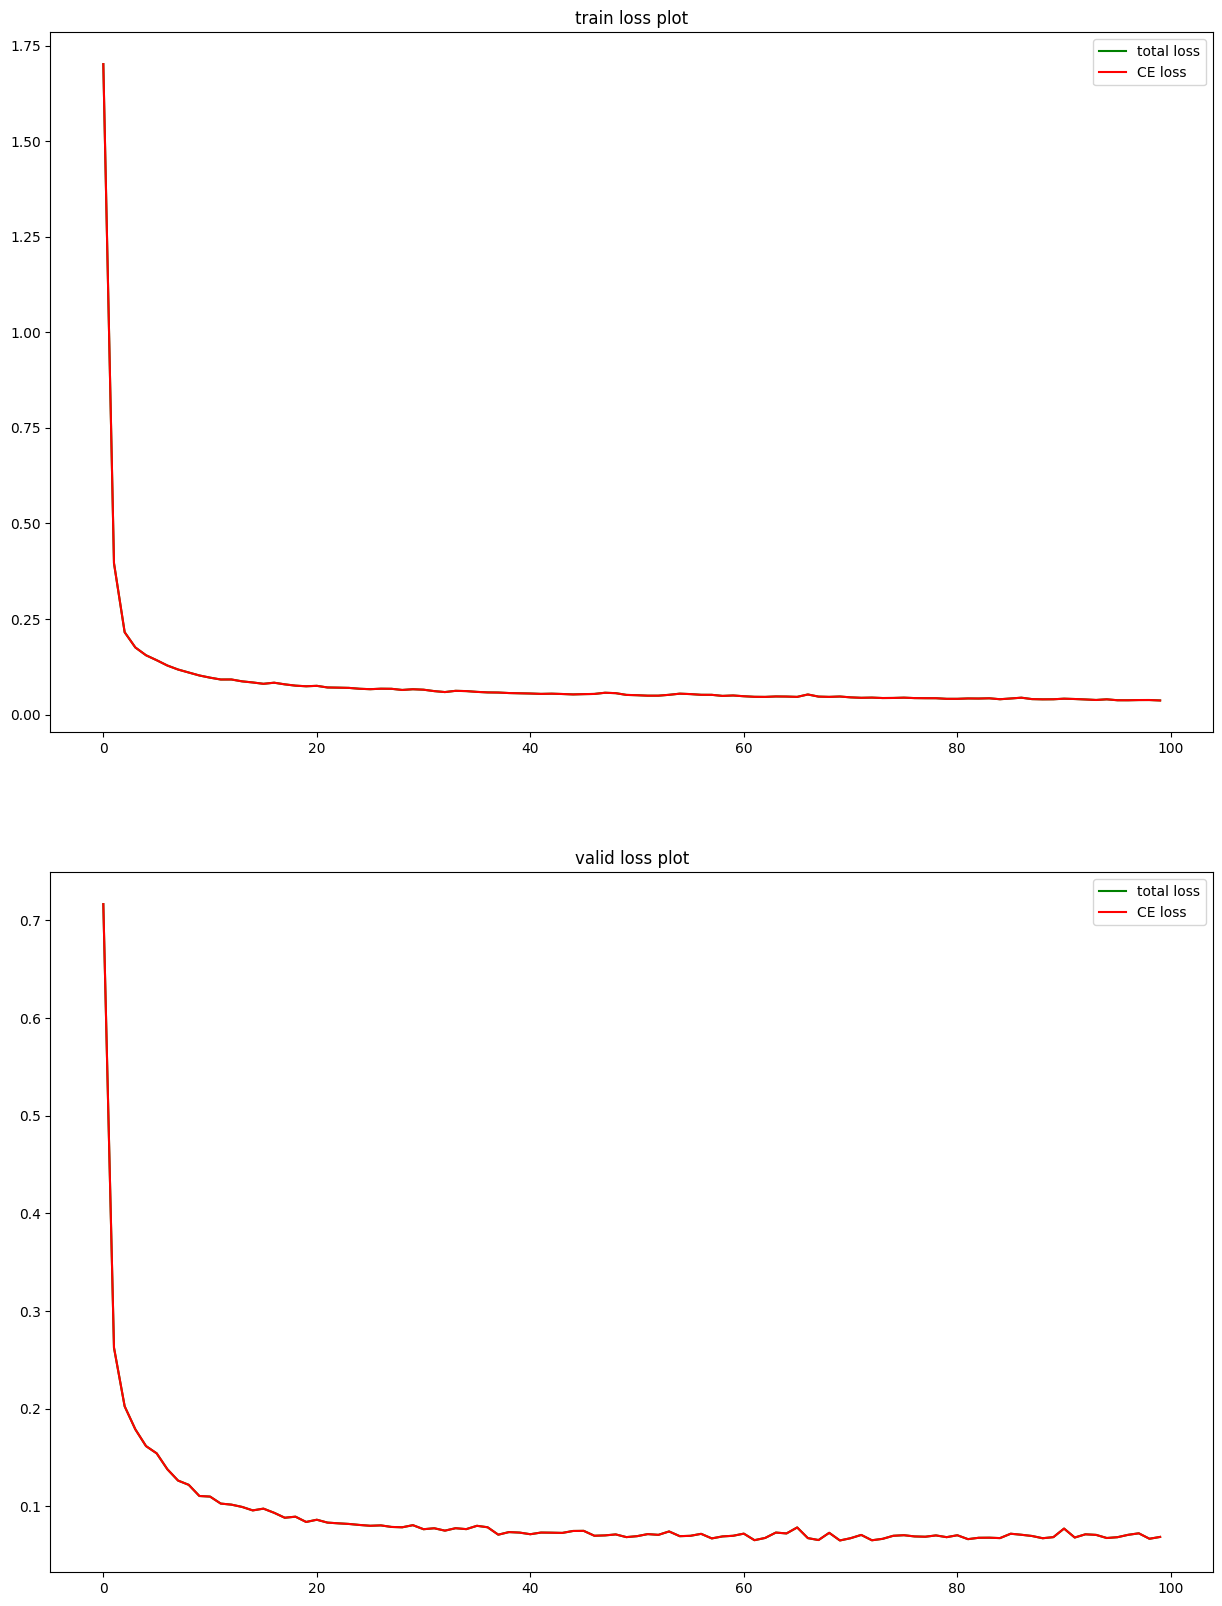

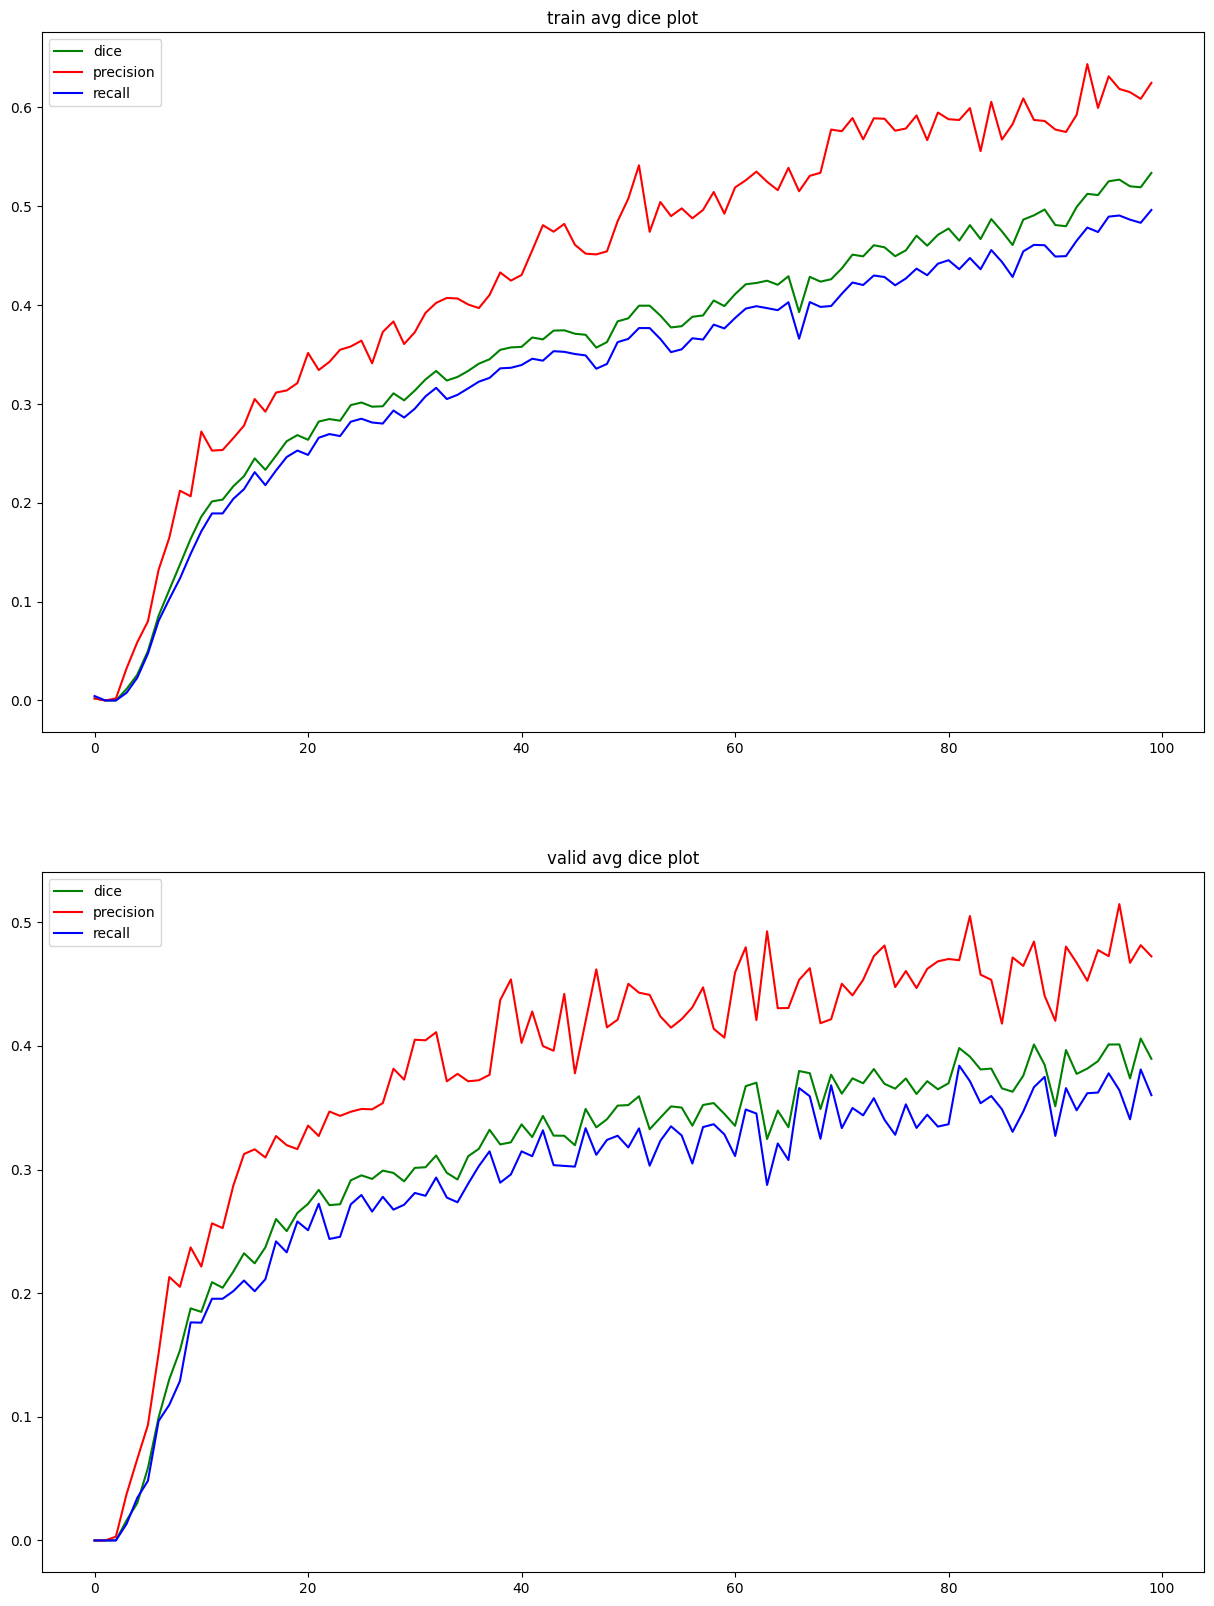

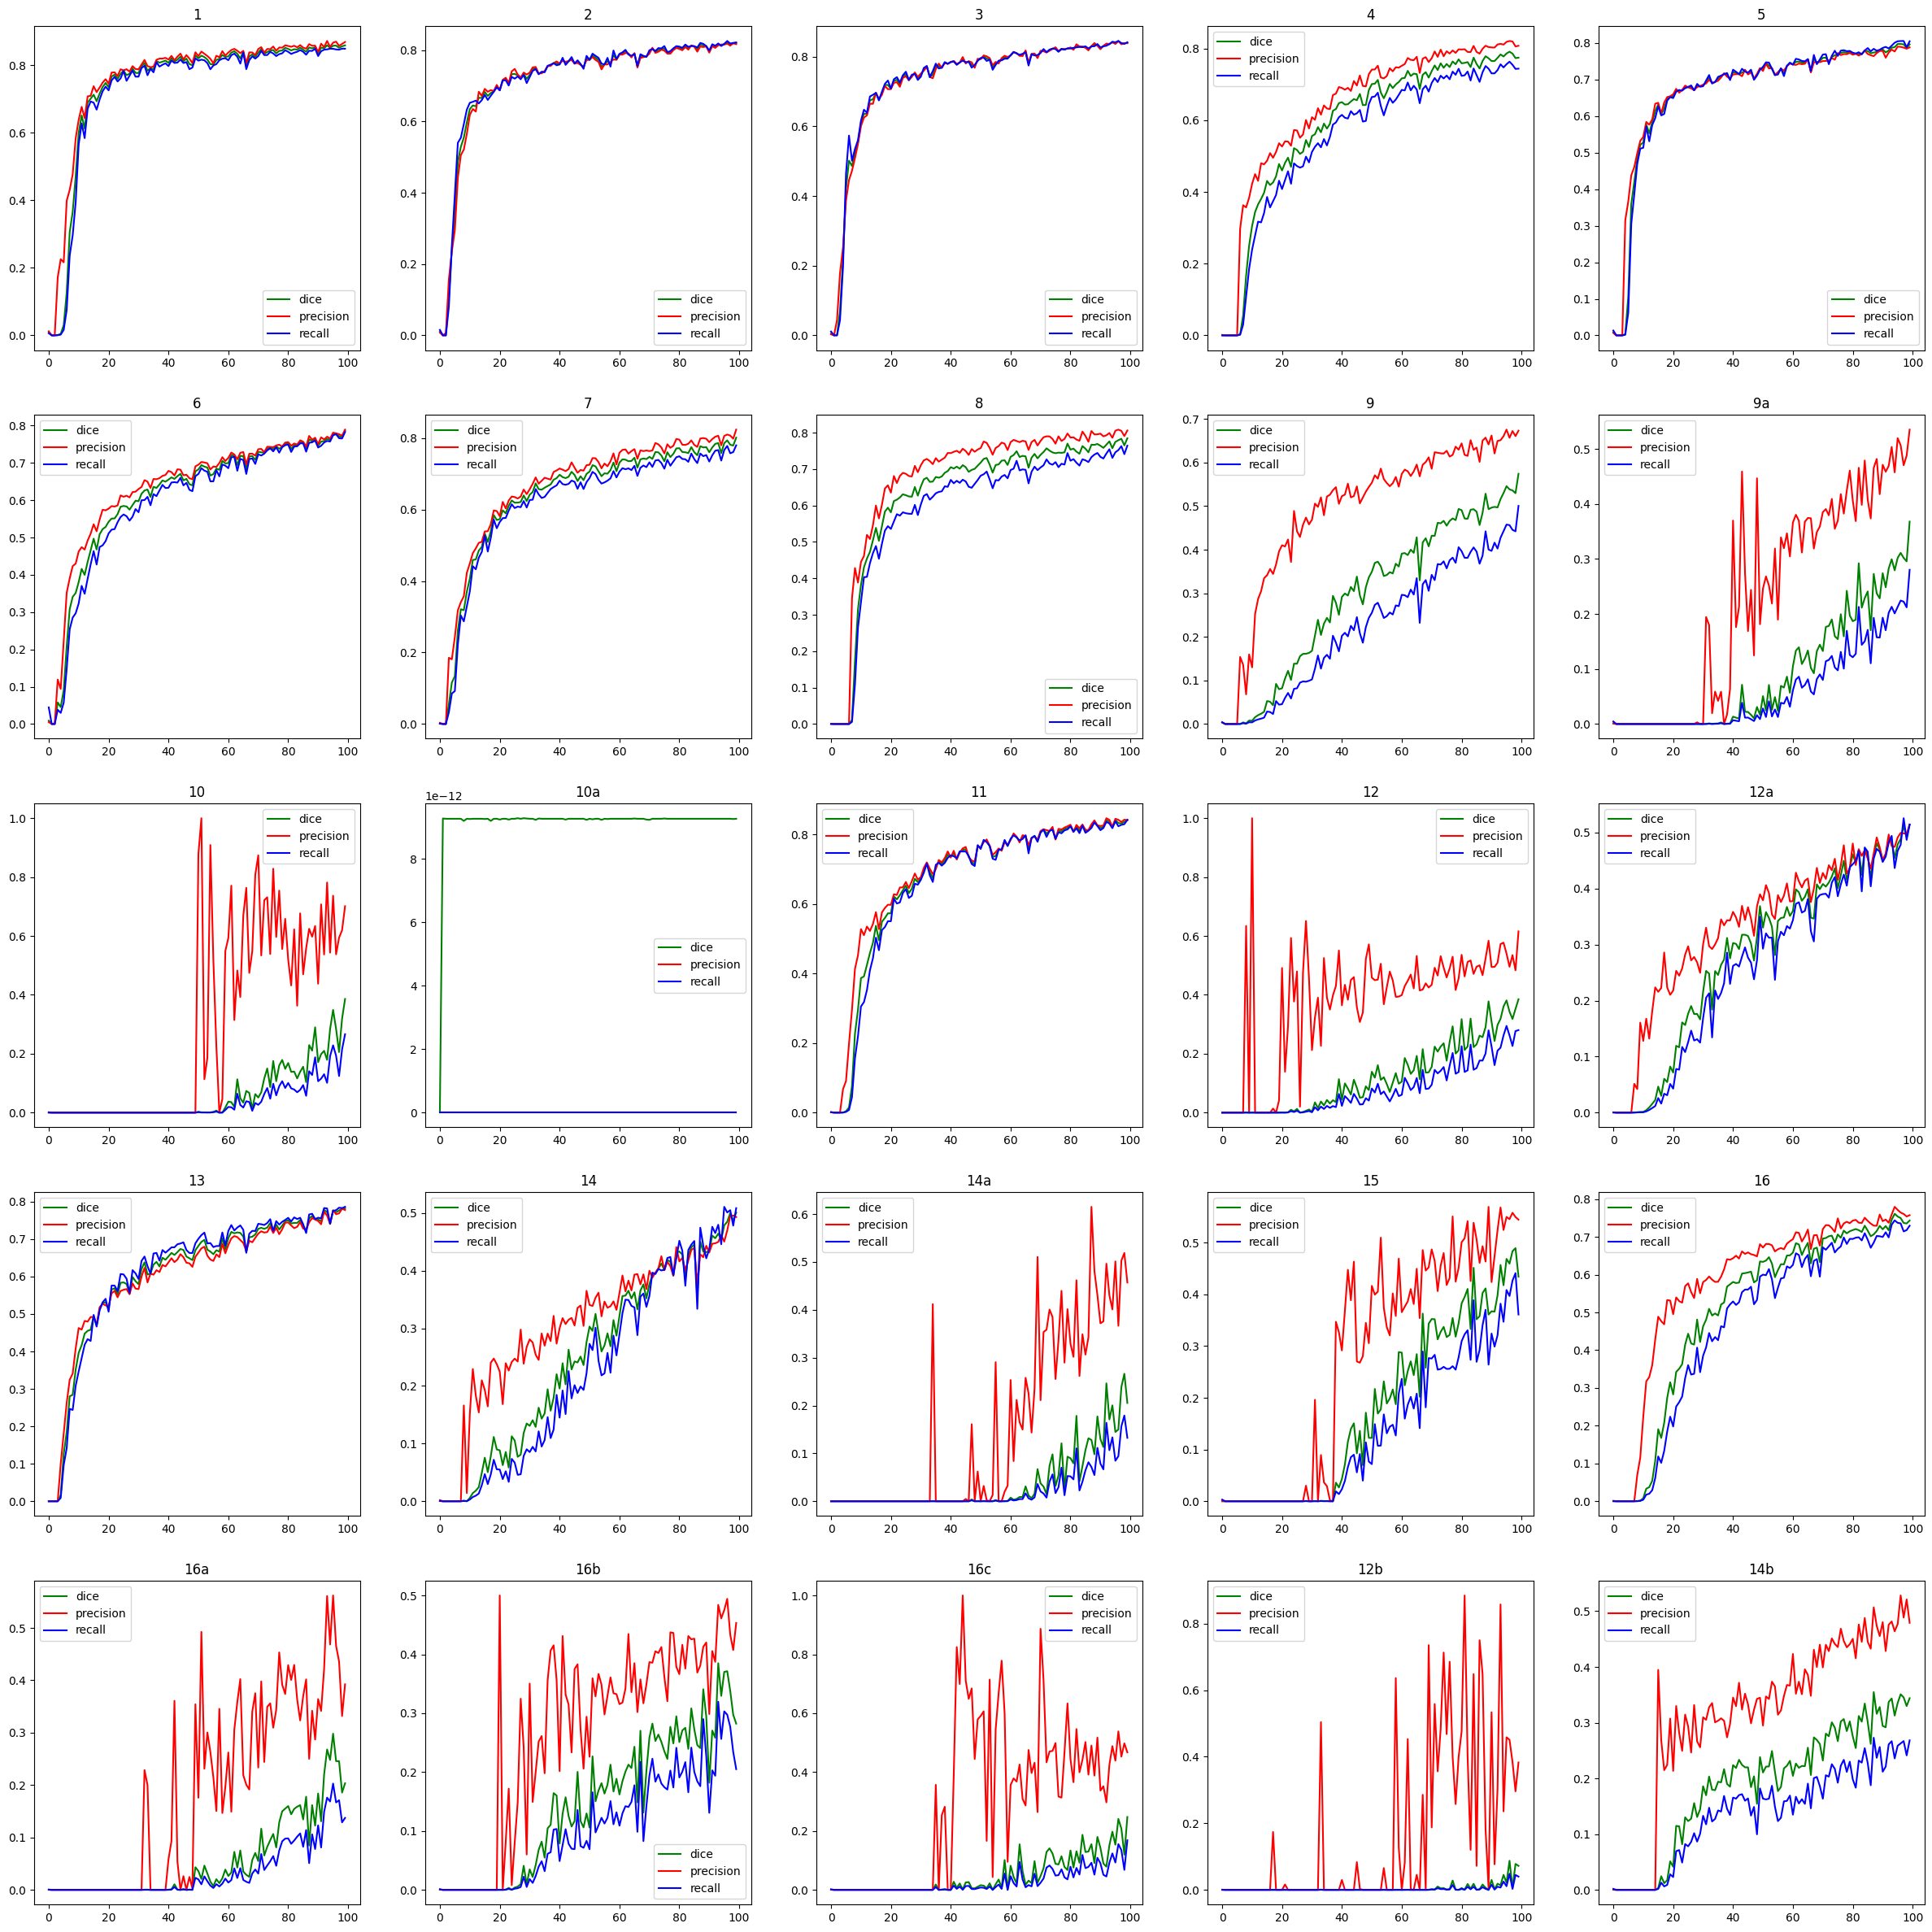

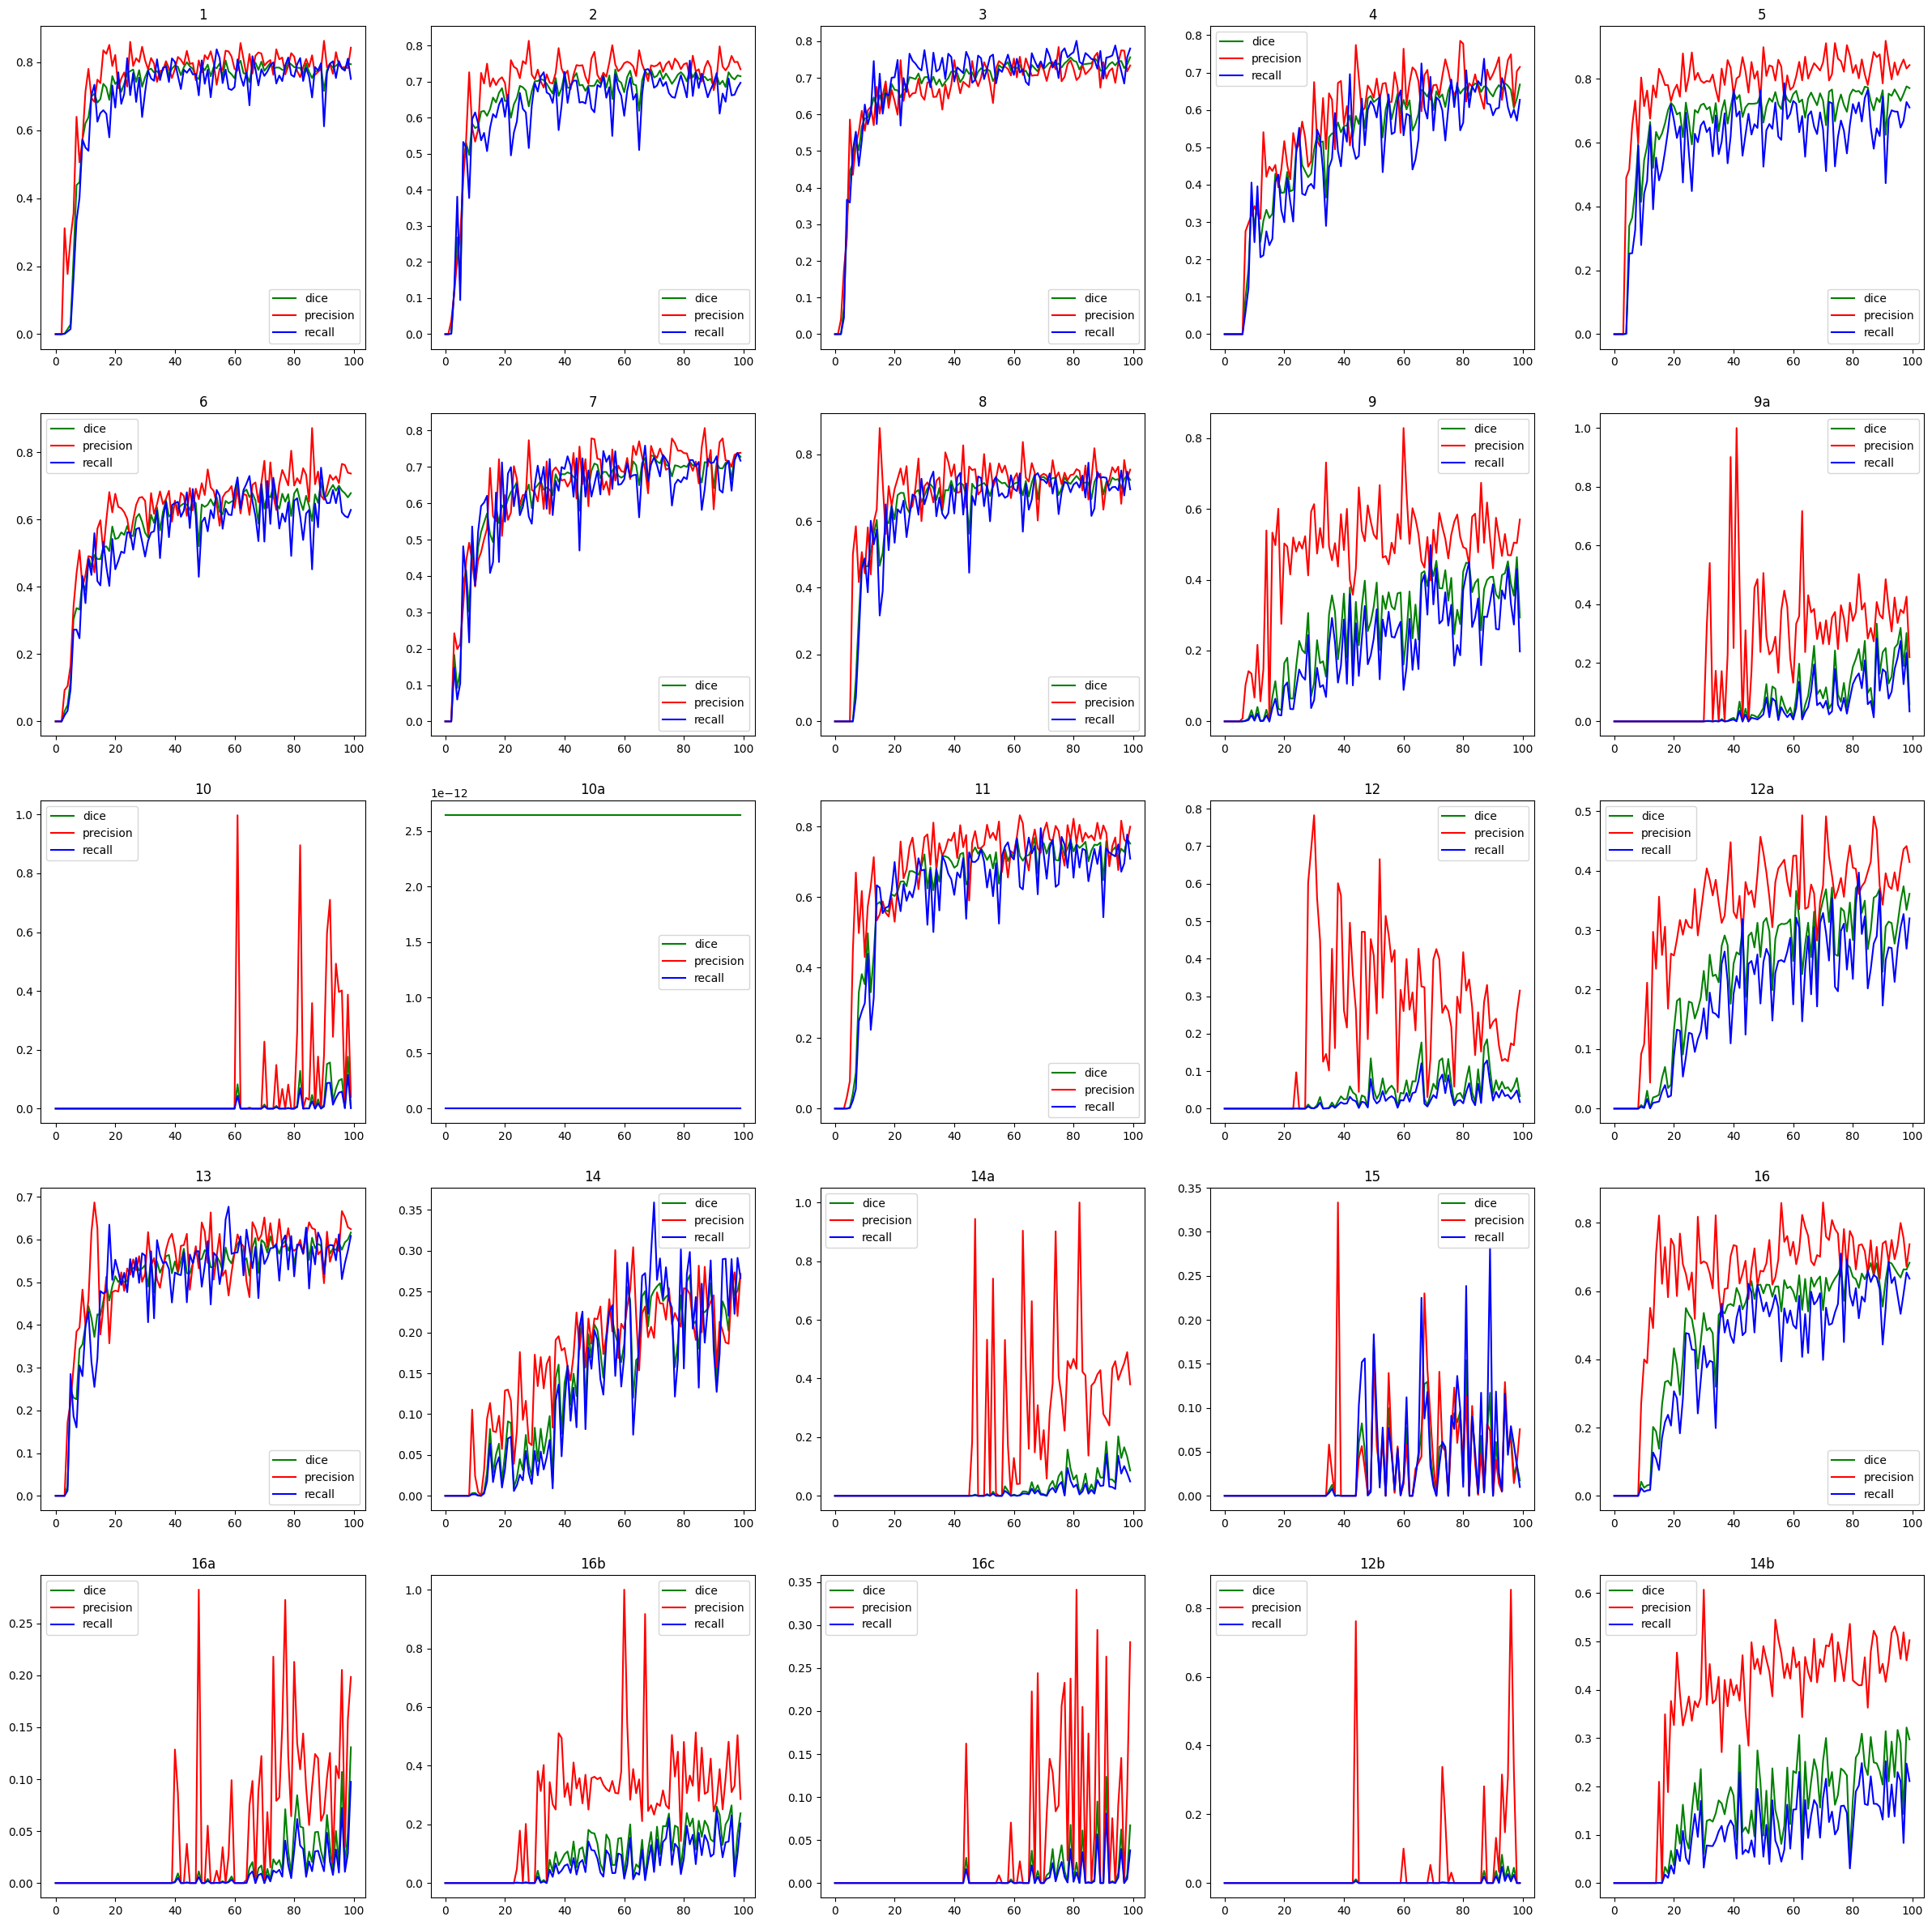

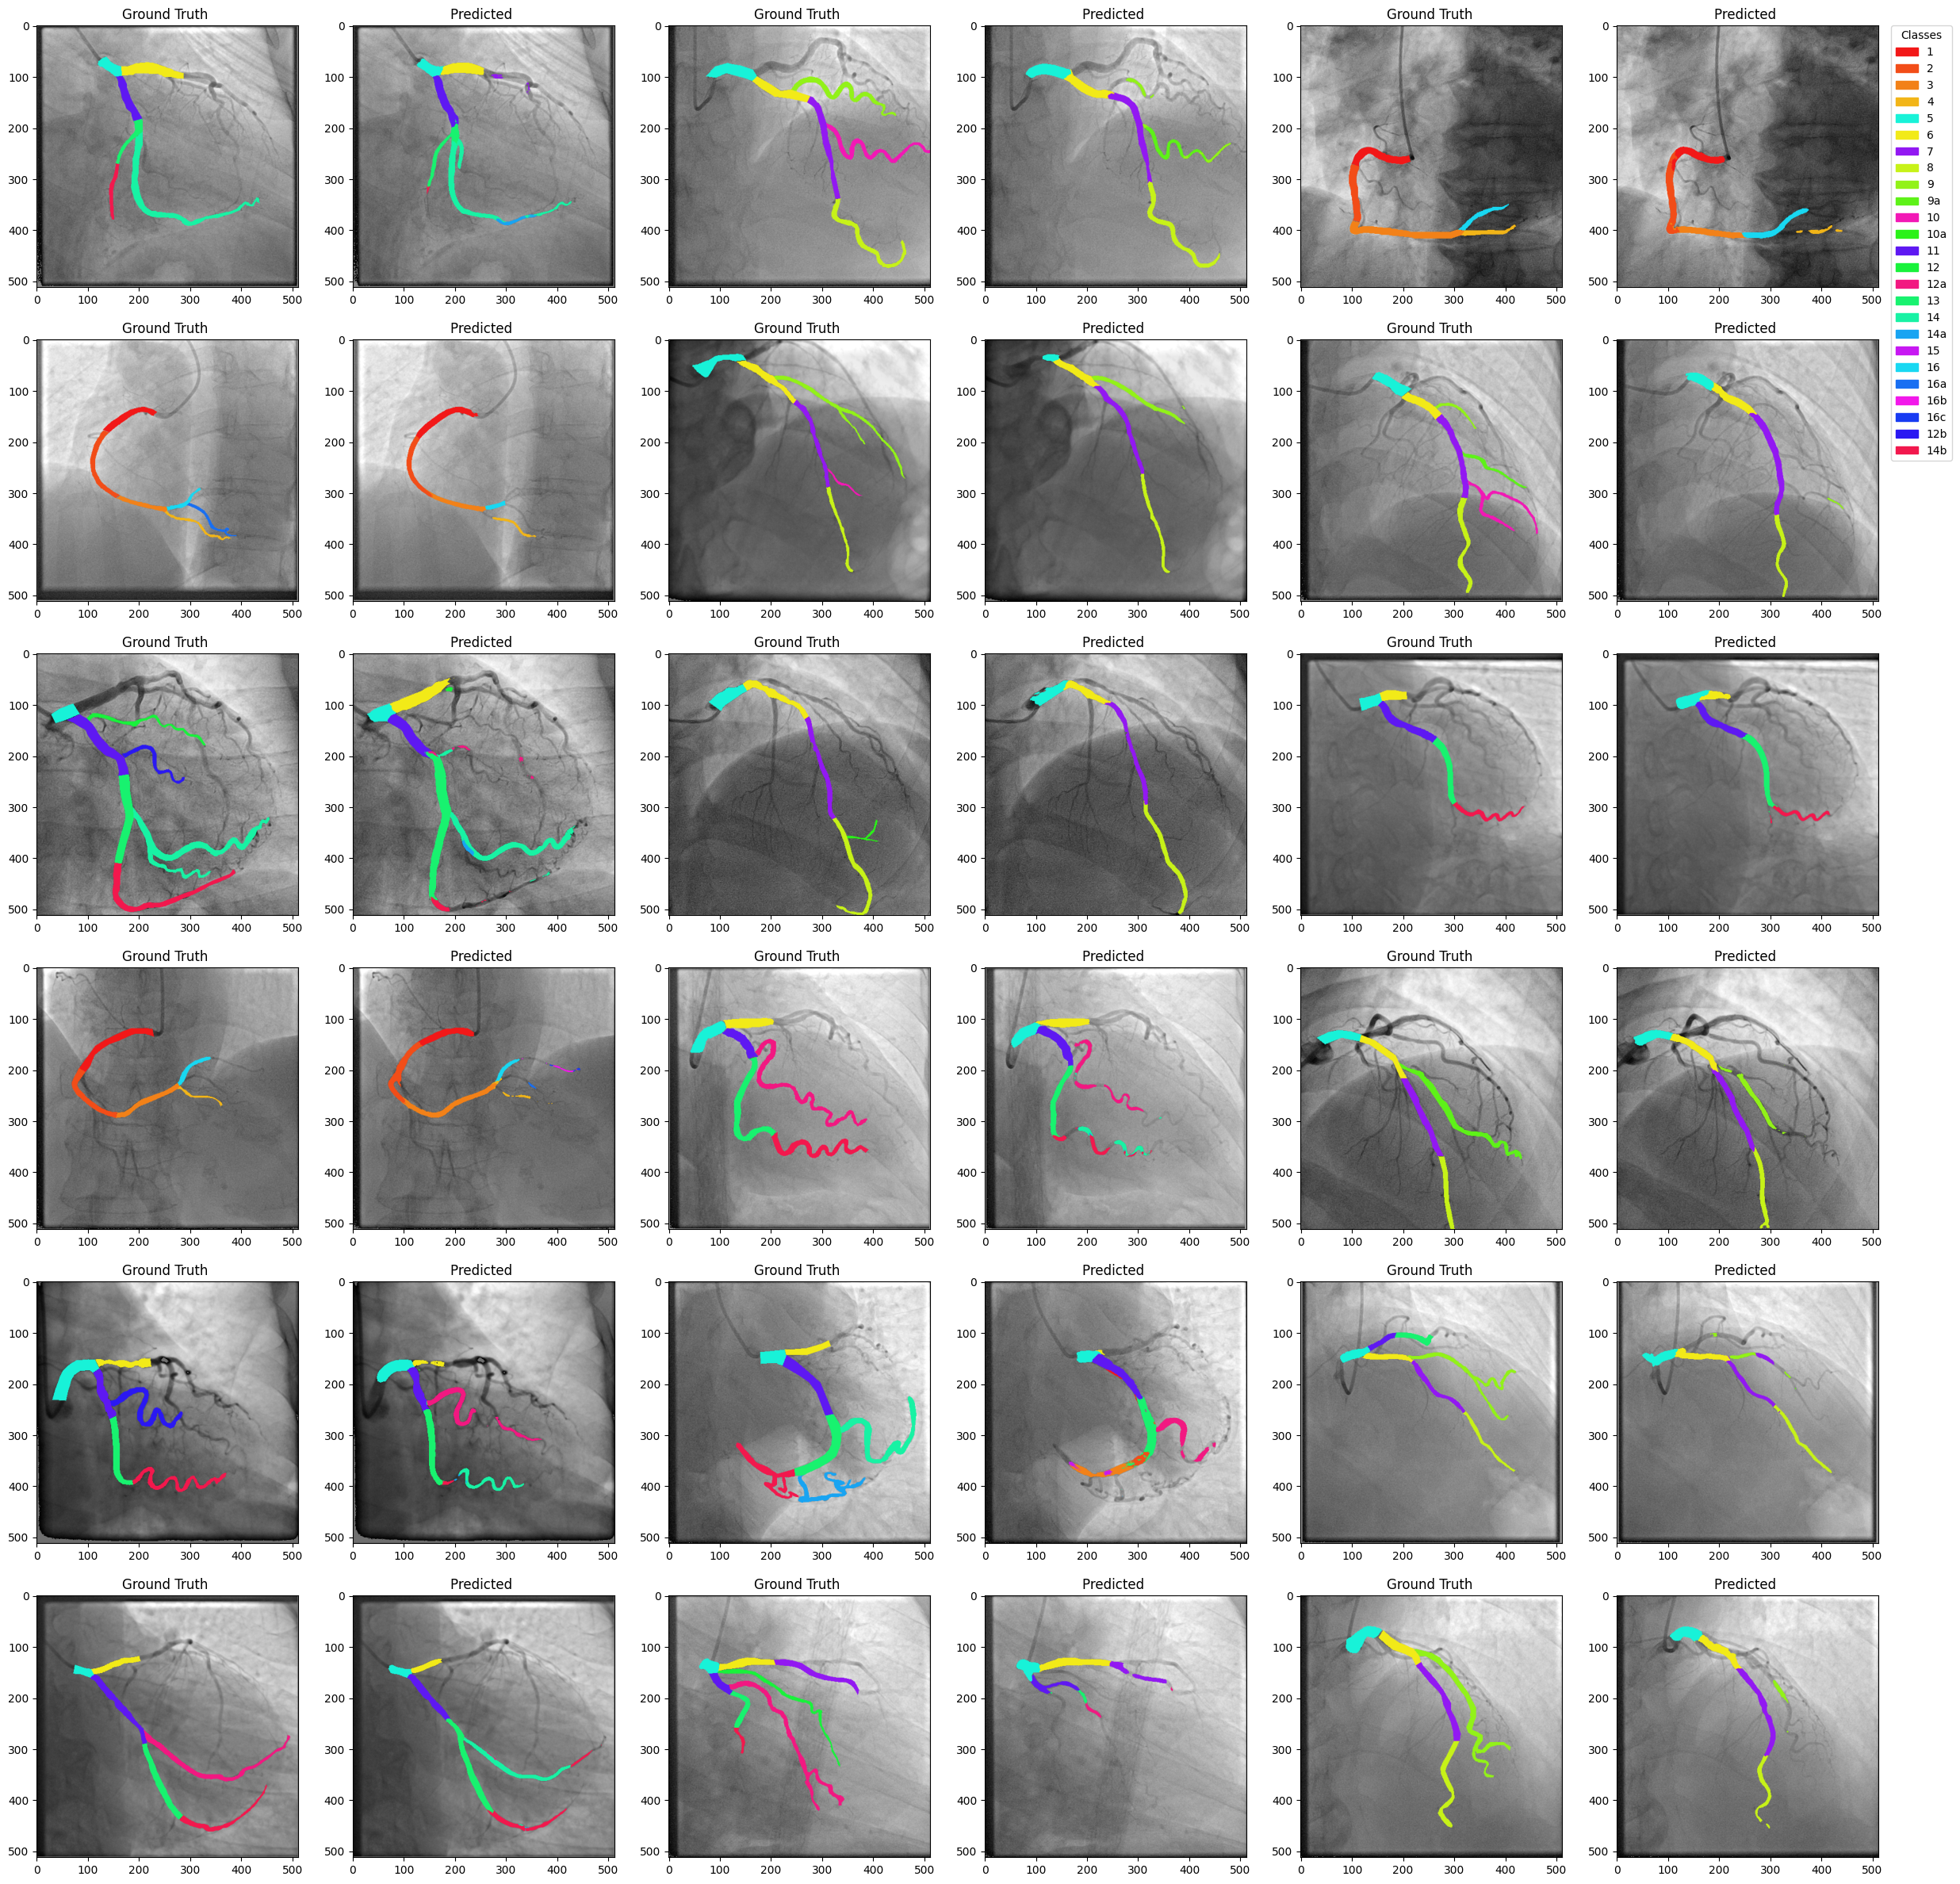

In [17]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)